In [1]:
import gzip
import pickle
import itertools
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from utils import standardize_data, plot_geodata_world

az.style.use('arviz-whitegrid')

In [2]:
# The dictionary containing results
results = dict()

# Utilities

## Useful Functions

In [3]:
def compute_mae(pred_values, true_values):
    # Compute the median of predictions
    pred_meds = np.median(pred_values.reshape(-1, len(true_values)), axis=0)
    return mean_absolute_error(true_values, pred_meds)

In [4]:
def compute_average_ll(trace):
    ll = trace.log_likelihood.to_array()
    mu_ll = ll.mean(axis=(0, 1))
    sigma_ll = 2.0 * ll.std(axis=(0, 1))
    return mu_ll.mean().item(), sigma_ll.mean().item()

In [5]:
def error_hdi50(pred_values, true_val):
    # Return whether the true value is out of the 50% HDI interval (and "how much") and its center
    q1, q2 = np.quantile(pred_values, [0.25, 0.75])
    qm = 0.5 * (q2 + q1)
    return (true_val < q1) or (true_val > q2), np.abs(true_val - qm)

## Useful Plotting Functions

In [6]:
def plot_weights_relevance(trace, features, var_name='beta', max_num=None, xlim=(-1, 1)):
    beta_dict = {k: trace.posterior[var_name][..., i] for i, k in enumerate(features)}
    beta_dict = {k: v for k, v in sorted(beta_dict.items(), key=lambda x: np.abs(np.median(x[1])), reverse=True)}
    if max_num is not None:
        assert max_num > 0
        beta_dict = {k: v for i, (k, v) in enumerate(beta_dict.items()) if i < max_num}
    axes = az.plot_forest(beta_dict, quartiles=True, combined=True, figsize=(8, 4))
    axes[0].set_xlim(xlim)
    axes[0].set_title('Posterior Feature Weights Distributions')
    plt.plot()

In [7]:
def plot_predictions(
    y_pred_trace, y_true, indices=None, sample_ids=None, transform=None,
    xlim=None, title=None, ax=None, figsize=(7, 6), show=True
):
    if indices is None:
        indices = np.arange(len(y_true))
    if sample_ids is None:
        sample_ids = np.arange(len(y_true))
    preds = {sample_ids[i]: y_pred_trace[:, i] for i in indices}
    trues = {sample_ids[i]: y_true[i] for i in indices}
    var_names = sample_ids[indices]
    if ax is not None:
        figsize = None
        show = False
    axes = az.plot_forest(
        [preds, trues], model_names=['Prediction', 'True'], var_names=var_names,
        transform=transform, quartiles=True, combined=True, colors=['C0', 'C3'], ax=ax, figsize=figsize
    )
    if xlim is not None:
        axes[0].set_xlim(xlim)
    if title is not None:
        axes[0].set_title(title)
    if show:
        plt.plot()

In [8]:
def plot_relevant_predictions(
    y_pred_trace, y_true, err_descending=True, max_num=10,
    sample_ids=None, transform=None, xlim=None, title=None, figsize=(7, 6)
):
    err50_infos = [error_hdi50(y_pred_trace[:, i], y_true[i]) for i in range(len(countries))]
    err50_indices = [i for i, _ in sorted(enumerate(err50_infos), key=lambda x: x[1][1], reverse=err_descending)]
    err50_indices = err50_indices[:max_num]
    plot_predictions(
        y_pred_trace, y_data, err50_indices, sample_ids=sample_ids, transform=transform,
        xlim=xlim, figsize=figsize, title=title
    )
    plt.plot()
    return err50_indices

In [9]:
def plot_predictions_compare(y_pred_trace1, y_pred_trace2, y_true, indices=None, sample_ids=None, transform=None,
    xlim=None, titles=None, figsize=(15, 6)
):
    if titles is None:
        titles = (None, None)
    fig, ax = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)
    plot_predictions(y_pred_trace1, y_true, indices=indices, sample_ids=sample_ids, transform=transform, xlim=xlim, title=titles[0], ax=ax[0])
    plot_predictions(y_pred_trace2, y_true, indices=indices, sample_ids=sample_ids, transform=transform, xlim=xlim, title=titles[1], ax=ax[1])
    plt.plot()

# Countries Yield Regression

## The Dataset

In [10]:
# Load the dataset
cy = pd.read_csv('data/yield_processed.csv', index_col=0)
cy

Area      Item    hg/ha_yield  avg_rain_mm_per_year  \
0     Albania  Potatoes  153105.043478                1485.0   
1     Albania     Wheat   31575.347826                1485.0   
2     Algeria  Potatoes  182413.956522                  89.0   
3     Algeria     Wheat   12009.913043                  89.0   
4      Angola  Potatoes   59085.739130                1010.0   
..        ...       ...            ...                   ...   
172   Uruguay     Wheat   24845.478261                1300.0   
173    Zambia  Potatoes  115800.652174                1020.0   
174    Zambia     Wheat   59848.347826                1020.0   
175  Zimbabwe  Potatoes  160965.434783                 657.0   
176  Zimbabwe     Wheat   43743.043478                 657.0   

     pesticides_kg_per_ha   avg_temp   lat   lon    elev  
0                2.184838  16.326957  41.0  20.0   708.0  
1                2.184838  16.326957  41.0  20.0   708.0  
2                1.110530  17.488261  28.0   3.0   800.0  
3                1.110530  17.488261  28.0   3.0   800.0  
4                0.027360  24.303043 -12.5  18.5  1112.0  
..                    ...        ...   ...   ...     ...  
172              6.608791  16.980870 -33.0 -56.0   109.0  
173              1.066569  21.064783 -15.0  30.0  1138.0  
174              1.066569  21.064783 -15.0  30.0  1138.0  
175              1.162260  20.831739 -20.0  30.0   961.0  
176              1.162260  20.831739 -20.0  30.0   961.0  

[177 rows x 9 columns]

### Potatoes Yield

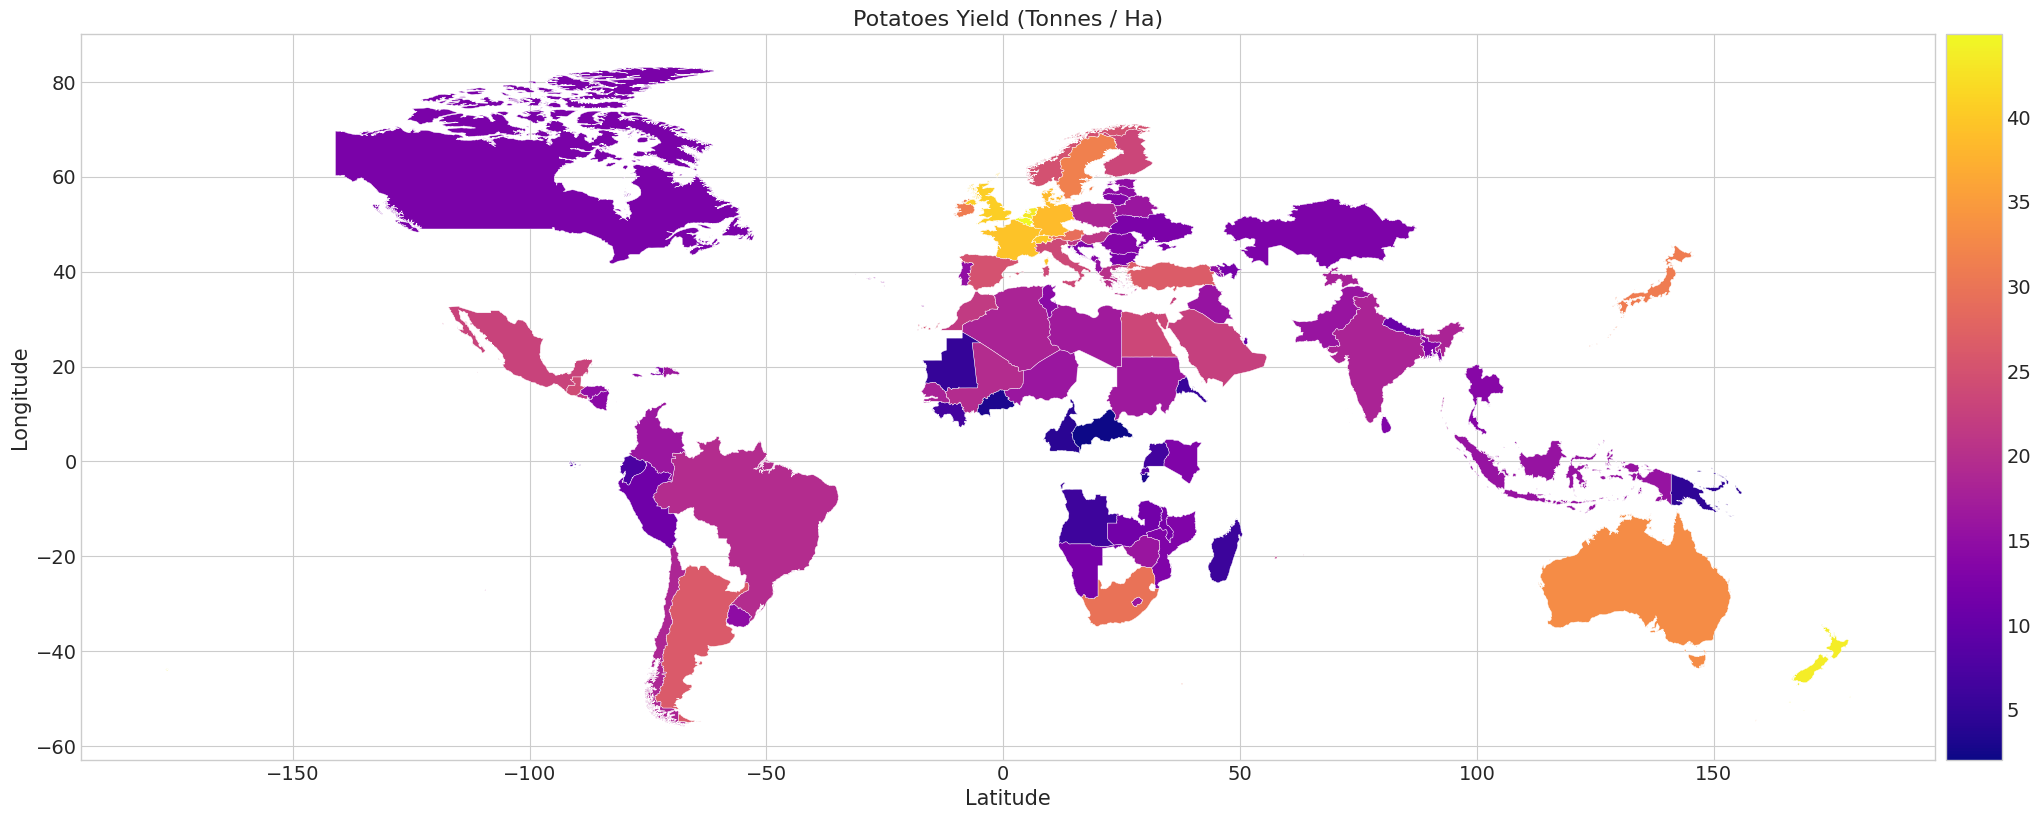

In [11]:
# Select Potatoes as item and remove country name feature
cyp = cy[cy['Item'] == 'Potatoes'].drop(columns='Item').reset_index(drop=True)
countries = cyp['Area'].unique()
cyp = cyp.drop('Area', axis=1)

# Plot the yield per country
plot_geodata_world(countries, cyp['hg/ha_yield'] * 1e-4, title='Potatoes Yield (Tonnes / Ha)')

### Features Standardization

In [12]:
# Get the features and the target feature
x_data = cyp.drop('hg/ha_yield', axis=1)
y_data = cyp['hg/ha_yield']
cyp.describe()

hg/ha_yield  avg_rain_mm_per_year  pesticides_kg_per_ha   avg_temp  \
count      95.000000             95.000000             95.000000  95.000000   
mean   181841.413334           1019.326316              3.143013  17.850083   
std     96668.731420            696.800613              4.049940   7.388661   
min     20516.217391             51.000000              0.003028   3.459565   
25%    127517.738095            577.000000              0.217843  10.646667   
50%    160965.434783            788.000000              1.590888  18.163478   
75%    224914.108696           1492.500000              4.085821  24.843652   
max    448891.538462           3240.000000             20.888427  29.718696   

             lat         lon         elev  
count  95.000000   95.000000    95.000000  
mean   21.398688   15.279380   637.568421  
std    27.141268   54.357624   586.573509  
min   -41.000000 -102.000000    28.000000  
25%     2.500000   -3.000000   297.500000  
50%    25.000000   20.000000   460.000000  
75%    44.083333   35.416667   826.500000  
max    64.000000  174.000000  3265.000000

In [13]:
# Set random seed
np.random.seed(42)

# Standardize the data
x_std_data, x_mean, x_stddev = standardize_data(x_data)
y_std_data, y_mean, y_stddev = standardize_data(y_data)

# Set the indices of the samples that will be used for evaluation
num_test_results = 10
test_indices = np.random.choice(len(y_data), size=num_test_results, replace=False)
test_indices = np.sort(test_indices)

## Exact Evaluation Metrics

Exact predictions can be obtained by computing the median of the predictions given by using the posterior distribution.
Let $y$ be the true target value and $\hat{y}$ its estimation.
The Mean Average Error ($\mathrm{MAE}$) is defined as follows.

$$\mathrm{MAE}(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^n \left| y_i - \hat{y}_i \right| \in [0, +\infty)$$

# Linear Regression

## Univariate Linear Regression

Probabilistically, a _linear regression_ model can be expressed as follows:

$$\mu = \alpha + \beta X$$
$$Y \sim \mathcal{N}(\mu, \epsilon)$$

where $X$ denotes the input feature, $Y$ denotes the target feature, and $\alpha$ and $\beta$ are respectively *intercept* and *slope* of the linear relationship.
So, the targets are assumed to be distributed as a Gaussian with mean $\alpha + \beta X$ and standard deviation $\epsilon$, which controls the amount of noise in our data.

Since we do not know the values of $\alpha$, $\beta$ or $\epsilon$, we have to set prior distributions for them.
A common yet reasonable choice for such distributions are the Gaussian and the non-negative Gaussian distribution (also called Half-Gaussian).

Alternatively, a prior distribution on the amount of noise can be the non-negative Cauchy distribution (also called Half-Cauchy), which have longer tails hence permitting to explore a wider space when sampling from the posterior.

$$\alpha \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha)$$
$$\beta \sim \mathcal{N}(\mu_\beta, \sigma_\beta)$$
$$\epsilon \sim |\mathcal{N}(0,\tau_\epsilon)| \quad\text{or}\quad \epsilon \sim |\mathcal{C}(0,\tau_\epsilon)|$$

## Multivariate Linear Regression

We can extend the _linear regression_ model for multivariate data with $d$ features as follows:

$$\mu = \alpha + X^T\beta = \alpha + \sum_{i=1}^d \beta_iX_i$$
$$y \sim \mathcal{N}(\mu, \epsilon)$$

where $X$ denotes the input features and Y denotes the target feature.
Note that we have different _slope_ parameters for each dimension.

Generally, linear regression enable a straightforward interpretation of parameters.
Each _slope_ parameter $\beta_i$ can be interpreted as the quantity to addition (or subtract) to the target variable $Y$, with a unit change of the $i$-th feature $X_i$.

In [14]:
def pymc3_linear_regression_model(
    x_data, y_data,
    eps_scale=5.0,
    alpha_mu=0.0, alpha_sd=8.0,
    beta_mu=0.0, beta_sd=8.0
):
    # Build a PyMC3 linear regression model
    with pm.Model() as model:
        # Intercept and slope priors
        alpha = pm.Normal('alpha', mu=alpha_mu, sd=alpha_sd)
        beta = pm.Normal('beta', mu=beta_mu, sd=beta_sd, shape=x_data.shape[1])

        # Fixed noise prior
        eps = pm.HalfCauchy('eps', eps_scale)

        # Likelihood
        mu = pm.Deterministic('mu', alpha + tt.dot(x_data, beta))
        y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y_data)
        return model

In [15]:
def pymc3_sample_predictions(model, trace, target_var='y_pred'):
    # Sample the predictions
    with model:
        ppc = pm.fast_sample_posterior_predictive(trace)
        pred_samples = ppc[target_var]
        return ppc, pred_samples

## Linear Regression with PyMC3

In [16]:
# Build a PyMC3 model for linear regression
model = pymc3_linear_regression_model(x_std_data, y_std_data)

# Sample from the posterior
with model:
    trace = pm.sample(
        draws=20_000, tune=10_000,
        chains=3, cores=3, random_seed=42,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eps, beta, alpha]


Sampling 3 chains for 10_000 tune and 20_000 draw iterations (30_000 + 60_000 draws total) took 32 seconds.


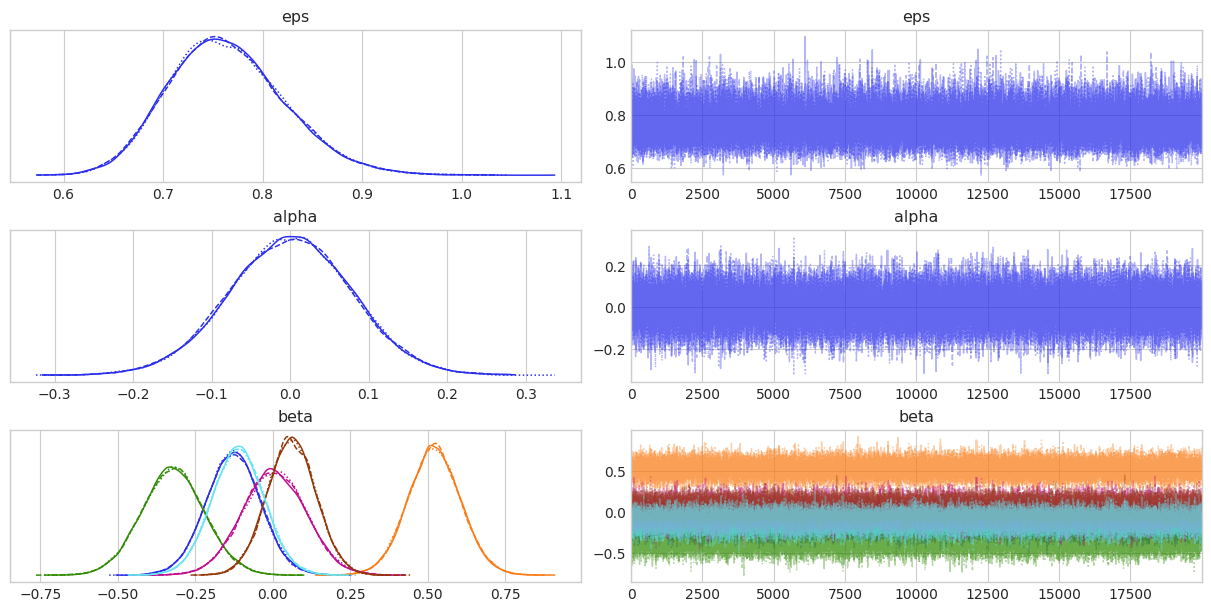

In [17]:
# Plot traces
az.plot_trace(trace, var_names=['eps', 'alpha', 'beta'])
plt.show()

[]

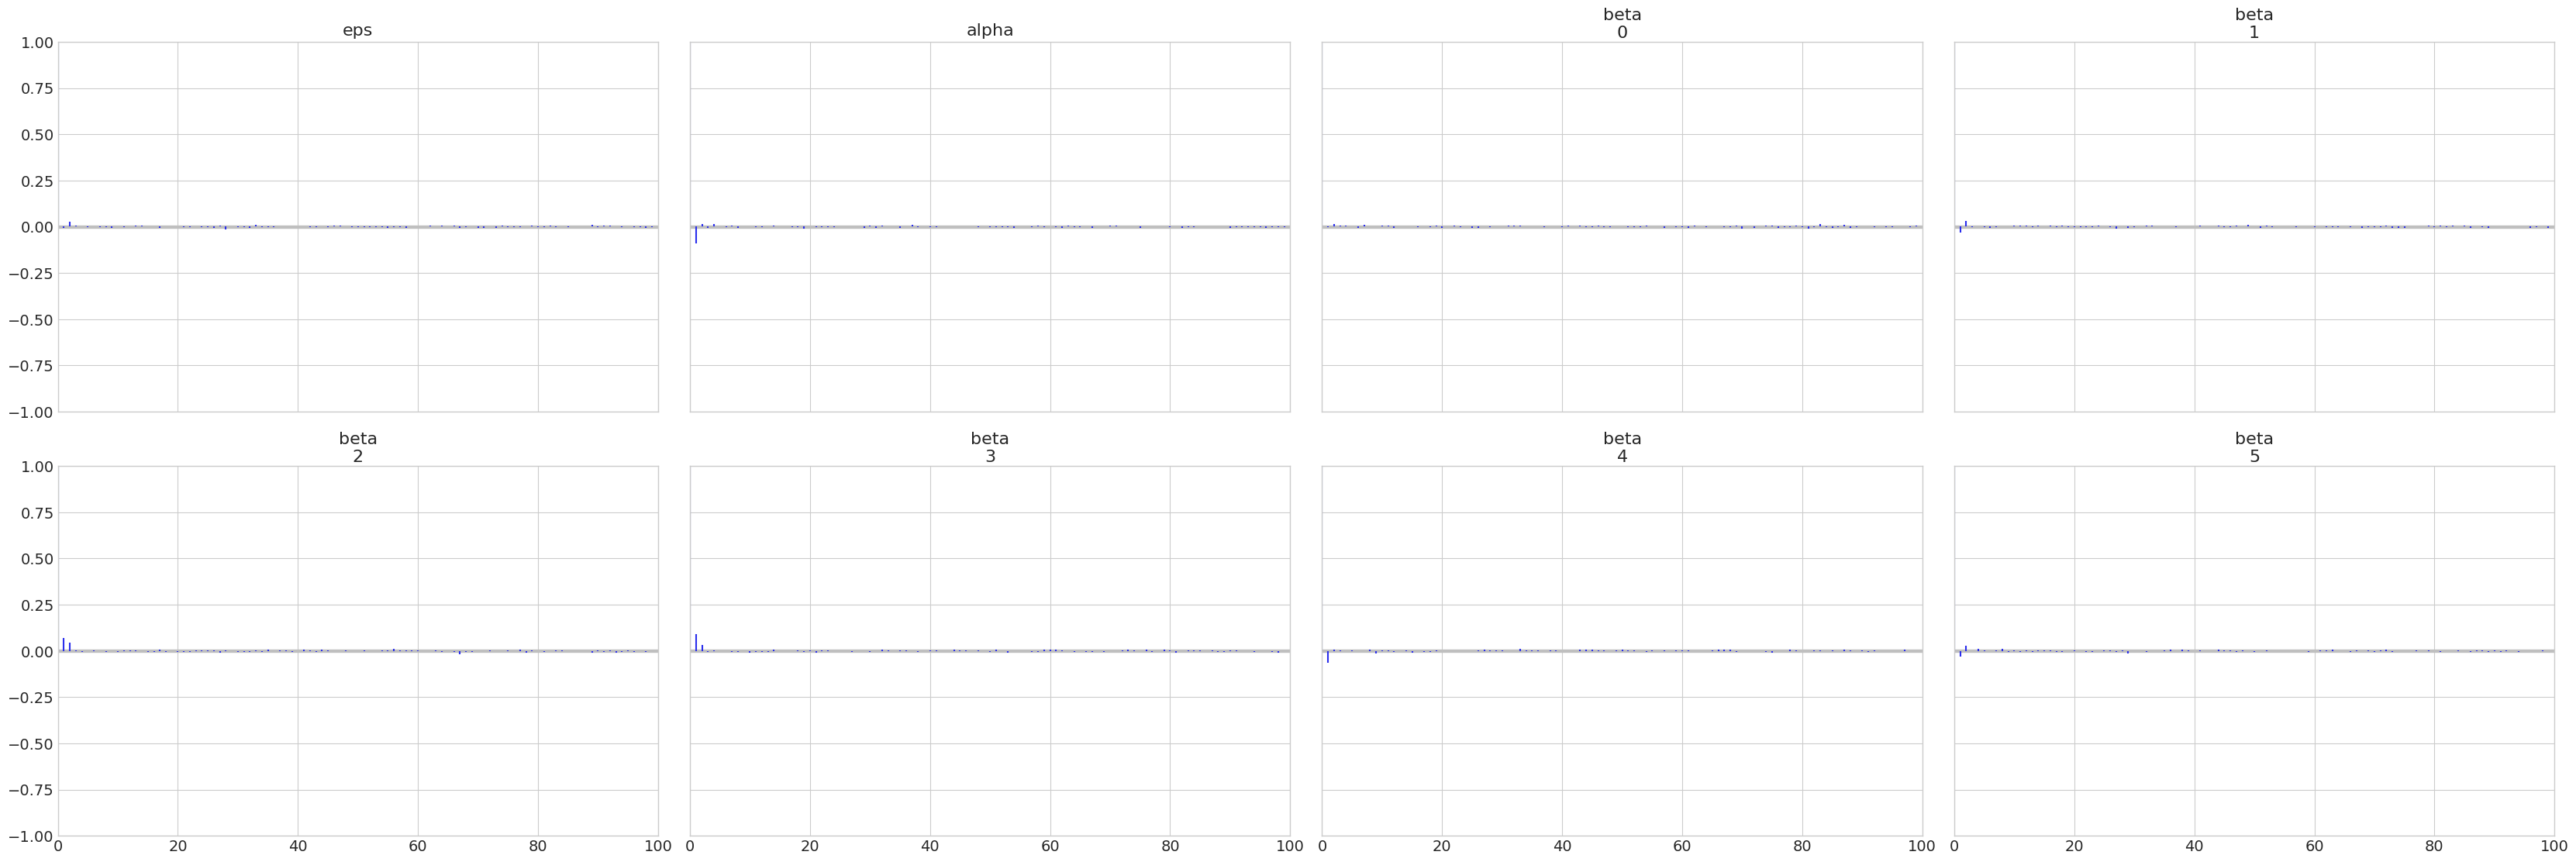

In [18]:
# Plot auto-correlation plots
az.plot_autocorr(trace, var_names=['eps', 'alpha', 'beta'], combined=True)
plt.plot()

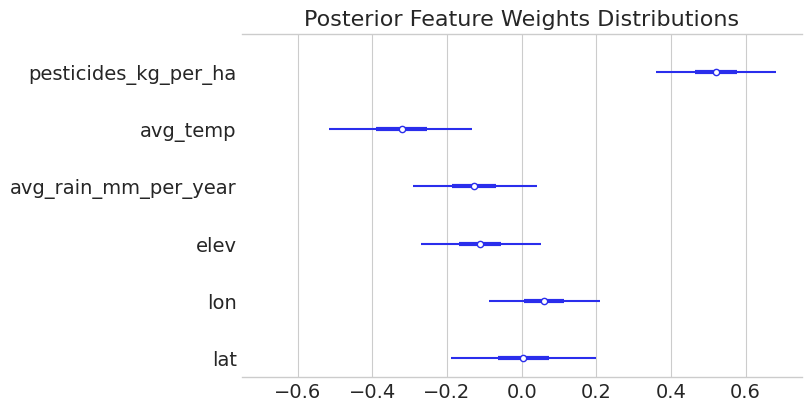

In [19]:
# Plot posterior feature weights distributions
plot_weights_relevance(trace, x_std_data.columns, xlim=(-0.75, 0.75))

Based on linear regression, the most useful features for the predictions are the usage of pesticides, the average temperature, the average ground elevation and the quantity of rain per year of the country.
The contribution to the predictions of longitude and latitude of the countries is negligible.

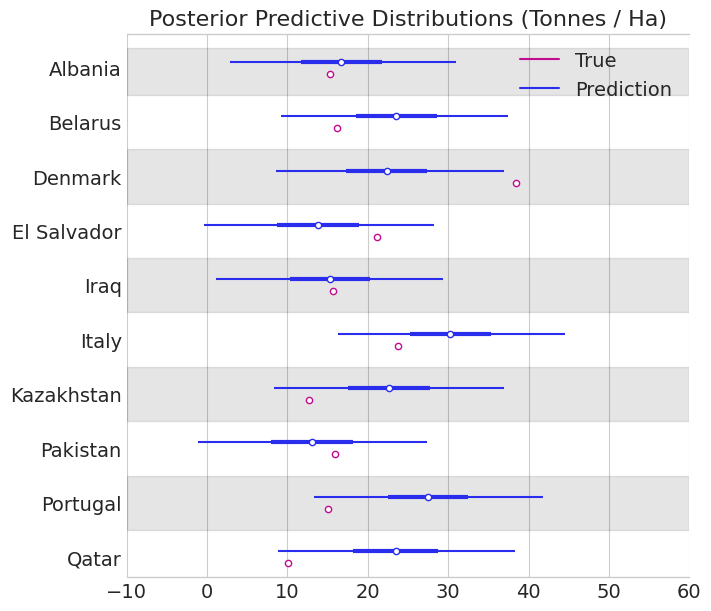

In [20]:
# Sample the predictions and plot them
ppc, pred_samples = pymc3_sample_predictions(model, trace)
pred_samples = y_stddev * pred_samples + y_mean
plot_predictions(
    pred_samples, y_data, test_indices, sample_ids=countries, transform=lambda x: 1e-4 * x,
    xlim=(-10, 60), title='Posterior Predictive Distributions (Tonnes / Ha)'
)

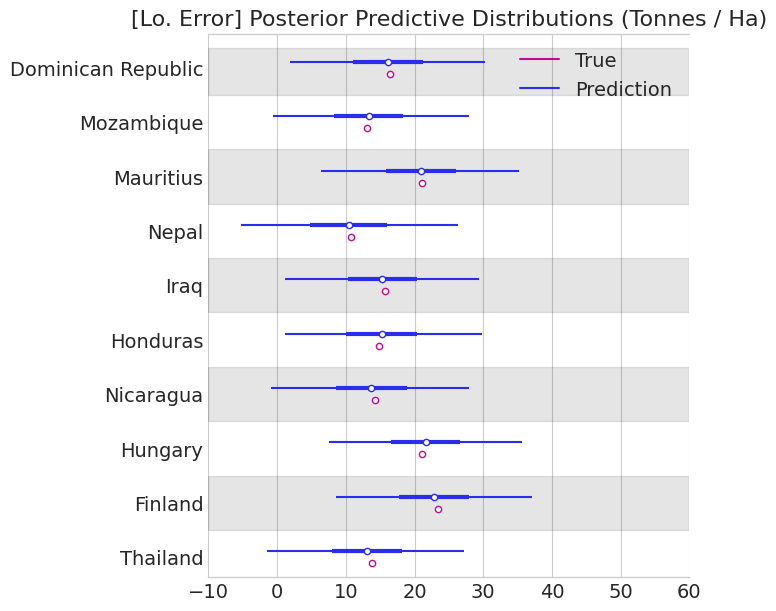

In [21]:
# Sort the predictions by taking the countries having smallest error
lo_err_indices = plot_relevant_predictions(
    pred_samples, y_data, err_descending=False, sample_ids=countries, transform=lambda x: 1e-4 * x,
    xlim=(-10, 60), title='[Lo. Error] Posterior Predictive Distributions (Tonnes / Ha)'
)

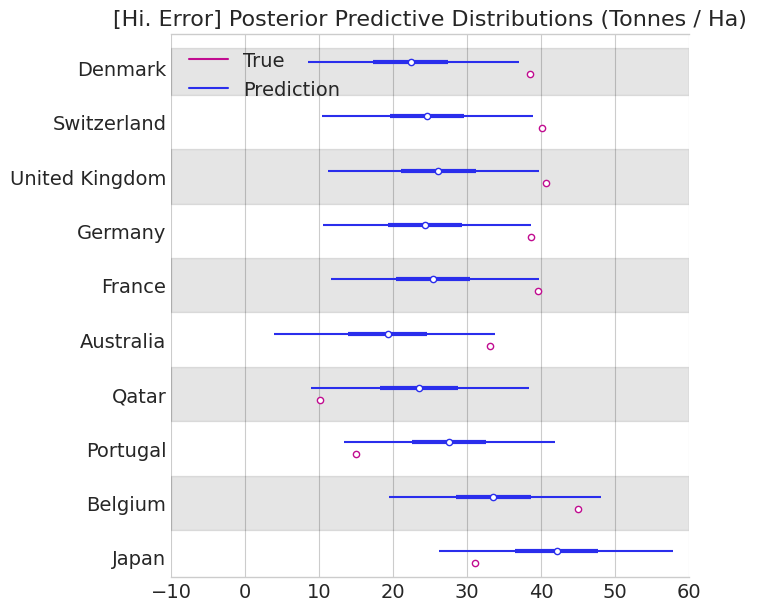

In [22]:
# Sort the predictions by taking the countries having highest error
hi_err_indices = plot_relevant_predictions(
    pred_samples, y_data, err_descending=True, sample_ids=countries, transform=lambda x: 1e-4 * x,
    xlim=(-10, 60), title='[Hi. Error] Posterior Predictive Distributions (Tonnes / Ha)'
)

[]

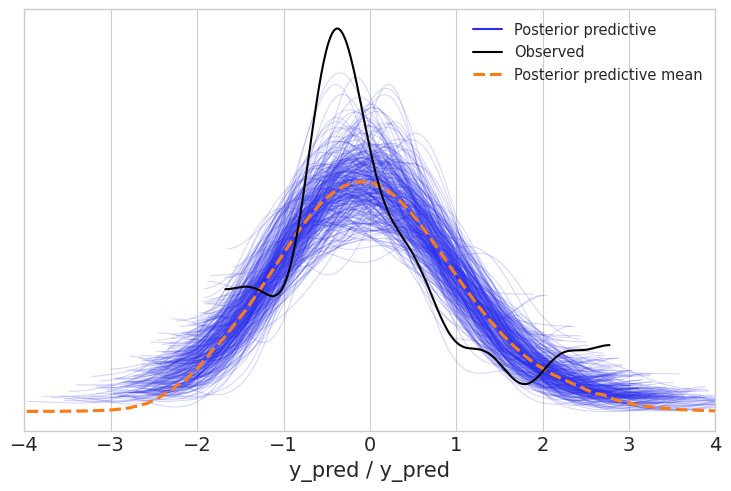

In [23]:
# Posterior predictive check
ppc_data = az.from_pymc3(posterior_predictive=ppc, model=model)
ax = az.plot_ppc(ppc_data, num_pp_samples=320)
ax.set_xlim((-4, 4))
plt.plot()

In [24]:
# Print the average log-likelihood
mu_ll, sigma_ll = compute_average_ll(trace)
print("Multivariate Linear Regression:")
print("Avg. LL: {:.2f} +- {:.2f}".format(mu_ll, sigma_ll))

Multivariate Linear Regression:
Avg. LL: -1.14 +- 0.33


In [25]:
# Print MAE
mae = compute_mae(pred_samples, y_data)
print("Multivariate Linear Regression:")
print("MAE: {:.2f} (Tonnes / Ha)".format(mae * 1e-4))

Multivariate Linear Regression:
MAE: 5.76 (Tonnes / Ha)


In [26]:
# Save results
results['linear'] = {
    'metrics': {'ll': (mu_ll, sigma_ll), 'mae': mae},
    'ppc_data': ppc_data,
    'pred_samples': pred_samples,
    'err_indices': (lo_err_indices, hi_err_indices)
}

# Polynomial Regression

## Univariate Polynomial Regression

Similarly to linear regression we introduce the _polynomial regression_ model as following.

$$\mu = \alpha + \sum_{i=1}^N \beta_iX^i = \alpha + \beta_1X + \beta_2X^2 + \ldots + \beta_NX^N$$
$$Y \sim \mathcal{N}(\mu,\epsilon)$$

where $N$ is the _degree_ of the polynomial.
Just like classical linear regression, we can impose prior distributions on the parameters of our model.

Polynomial regression is useful in cases we need to model _non-linear characteristics_ of a target variable with respect to the other features.
However, one problem of polynomial regression is that interpreting the weights $\beta_i$ is difficult.
That is, fixing a feature $X$ we have several weights (each for the $i$-th power) that influence the value of the target variable, and they can also be positive or negative independently.

Another problem is that it is always possible to find a polynomial that _perfectly fits_ the data.
However, fitting _perfectly_ the data is not a good idea since the resultinig model will not be a good representation of _un-observed_ data.
This is known as **overfitting**.

In [27]:
def plot_overfitting_polynomial(n1, n2):
    # Initialize a random state
    random_state = np.random.RandomState(42)
    
    # Load one of the Anscombe quartet
    data = pd.read_csv('data/anscombe.csv')
    x = data[data.group == 'II']['x'].to_numpy()[:, np.newaxis]
    y = data[data.group == 'II']['y'].to_numpy()
    x += 0.5 * random_state.randn(*x.shape)
    y += 0.5 * random_state.randn(*y.shape)
    
    # Fit polynomials
    poly1 = PolynomialFeatures(degree=n1)
    poly2 = PolynomialFeatures(degree=n2)
    model1 = LinearRegression().fit(poly1.fit_transform(x), y)
    model2 = LinearRegression().fit(poly2.fit_transform(x), y)
    x_pred = np.linspace(x.min() - 0.1, x.max() + 0.1, 300)[:, np.newaxis]
    y_pred1 = model1.predict(poly1.transform(x_pred));
    y_pred2 = model2.predict(poly2.transform(x_pred))

    # Plot the data and the fitting polynomial
    plt.figure(figsize=(6, 4))
    plt.scatter(x.squeeze(), y, s=16, c='k', label='Data Points')
    plt.plot(x_pred, y_pred1, label='Poly. N={}'.format(poly1.degree))
    plt.plot(x_pred, y_pred2, label='Poly. N={}'.format(poly2.degree))
    plt.xlabel('x')
    plt.ylabel('y', rotation=0)
    plt.legend()
    plt.show()

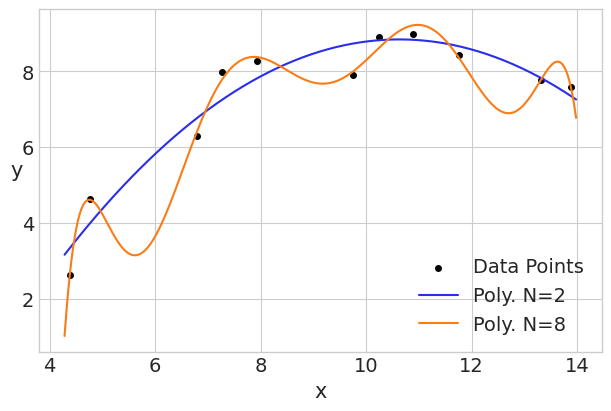

In [28]:
plot_overfitting_polynomial(n1=2, n2=8)

Polynomial regression can be performed easily using linear regression on the _augmented_ data built based on the polynomial grade. 
In regression analysis, we can refer to the _augmented_ data matrix with possibly additional interactions between features as the **design matrix**.

In other words, we _expand the feature space_ and then fit a linear regression model in the expanded space.
We can generalize this concept by introducing **basis functions** $B_i:\mathbb{R}\to\mathbb{R}$.

$$\mu = \alpha + \sum_{i=1}^M \beta_iB_i(X) = \alpha + \beta_1B_1(X) + \beta_2B_2(X) + \ldots + \beta_MB_M(X)$$
$$Y \sim \mathcal{N}(\mu,\epsilon)$$

When $B_i$ is the $i$-th power function, we recover the univariate polynomial regression model.
This can be generalized as well also for multivariate data.

## Multivariate Polynomial Regression

Dealing with multivariate data, in the classical formulation of linear regression we have assumed that the effect of each feature on the target feature is independent with respect to the other features. However, this is not always the case, e.g. different drugs interactions and positive or negative effects on a patient. Modeling this kind of phenomena requires the introduction of _interaction effects_.

For example, given two features $X_1$ and $X_2$, a linear model incorporating interaction effects between them can be described as follows:

$$\mu = \alpha + \beta_1X_1+\beta_2X_2+\beta_3X_1X_2$$
$$Y \sim \mathcal{N}(\mu, \epsilon)$$

where $\beta_3$ is the coefficient for the interaction term $X_1X_2$. Just like classical linear regression, we can impose prior distributions on the parameters of our model.

Interaction effects are the main components of a **multi-variate polynomial regression** model.
Fore example, given three features $X_1,X_2,X_3$, a quadratic multi-variate regression model can be described as follows.

$$\mu = \alpha + \beta_1X_1 + \beta_2X_2 + \beta_3X_3 + \beta_4X_1X_2 + \beta_5X_2X_3 + \beta_6X_1X_3 + \beta_7X_1^2 + \beta_8X_2^2 + \beta_9X_3^2$$
$$Y \sim \mathcal{N}(\mu, \epsilon)$$

Given $d$ the number of features and $N$ the grade of the polynomial, the number of terms appearing in $\mu$ is the number of _combinations with replacement_ of $d+1$ objects in groups of $N$, and we can write:

$$\binom{(d + 1) + N - 1}{N} = \binom{d+N}{N} = \mathcal{O}(d^N)$$

However, we can decide to discard some un-promising interactions between features to tackle down the computational complexity, e.g. considering only interactions between features without powers.
This is equivalent to putting to zero some _slopes_ appearing in the polynomial.

In [29]:
def design_matrix_polynomial(df, n, interaction_only=False):
    assert 0 < n <= df.shape[1]

    # n=1: just return the input data
    if n == 1:
        return df

    # n>1: compute all the combinations (with our without replacement)
    columns = {i: c for i, c in enumerate(df.columns)}
    if interaction_only:
        combinations = list(itertools.combinations(range(len(columns)), n))
    else:
        combinations = list(itertools.combinations_with_replacement(range(len(columns)), n))

    def build_header_features(features):
        fs, cs = np.unique(features, return_counts=True)
        return '*'.join([
            columns[i] if j == 1 else '{}^{}'.format(columns[i], j)
            for i, j in zip(fs, cs)
        ])

    # Multiply features and also headers
    dm = np.array([
        np.product([df[columns[i]] for i in features], axis=0)
        for features in combinations
    ]).T
    header = [build_header_features(features) for features in combinations]

    # Concatenate design matrices recursively
    dm = pd.DataFrame(dm, columns=header)
    return pd.concat([design_matrix_polynomial(df, n - 1, interaction_only=interaction_only), dm], axis=1)

We define the method `design_matrix_polynomial` that computes the corresponding polynomial design matrix of a given grade.
Moreover, with `interaction_only=True` we can exclude resulting features computed using powers of a single feature.

In [30]:
df = pd.DataFrame({'X': [0.3, 0.5, -1.0, 0.2], 'Y': [0.5, 1.0, 1.0, 0.5], 'Z': [2.0, -0.8, 0.7, -0.1]})
display(df)
display(design_matrix_polynomial(df, n=2))
display(design_matrix_polynomial(df, n=2, interaction_only=True))

X    Y    Z
0  0.3  0.5  2.0
1  0.5  1.0 -0.8
2 -1.0  1.0  0.7
3  0.2  0.5 -0.1

X    Y    Z   X^2   X*Y   X*Z   Y^2   Y*Z   Z^2
0  0.3  0.5  2.0  0.09  0.15  0.60  0.25  1.00  4.00
1  0.5  1.0 -0.8  0.25  0.50 -0.40  1.00 -0.80  0.64
2 -1.0  1.0  0.7  1.00 -1.00 -0.70  1.00  0.70  0.49
3  0.2  0.5 -0.1  0.04  0.10 -0.02  0.25 -0.05  0.01

X    Y    Z   X*Y   X*Z   Y*Z
0  0.3  0.5  2.0  0.15  0.60  1.00
1  0.5  1.0 -0.8  0.50 -0.40 -0.80
2 -1.0  1.0  0.7 -1.00 -0.70  0.70
3  0.2  0.5 -0.1  0.10 -0.02 -0.05

# Polynomial Regression with PyMC3

## Full Quadratic Regression

In [31]:
# Build design matrix for polynomial regression with grade 2
features = ['pesticides_kg_per_ha', 'avg_temp', 'elev', 'avg_rain_mm_per_year']
p_dataset = design_matrix_polynomial(x_data[features], n=2)

# Standardize the data
p_dataset, p_mean, p_stddev = standardize_data(p_dataset)
p_dataset.describe()

pesticides_kg_per_ha      avg_temp          elev  avg_rain_mm_per_year  \
count          9.500000e+01  9.500000e+01  9.500000e+01          9.500000e+01   
mean          -4.090295e-18  1.110223e-16 -3.856564e-17         -2.571043e-17   
std            1.005305e+00  1.005305e+00  1.005305e+00          1.005305e+00   
min           -7.794295e-01 -1.957981e+00 -1.044715e+00         -1.397047e+00   
25%           -7.261067e-01 -9.801006e-01 -5.828298e-01         -6.381637e-01   
50%           -3.852796e-01  4.264066e-02 -3.043275e-01         -3.337447e-01   
75%            2.340307e-01  9.515486e-01  3.238023e-01          6.826686e-01   
max            4.404894e+00  1.614850e+00  4.503051e+00          3.203864e+00   

       pesticides_kg_per_ha^2  pesticides_kg_per_ha*avg_temp  \
count            9.500000e+01                   9.500000e+01   
mean            -5.901712e-17                  -5.843279e-19   
std              1.005305e+00                   1.005305e+00   
min             -4.074095e-01                  -7.475924e-01   
25%             -4.066677e-01                  -6.753082e-01   
50%             -3.679150e-01                  -4.538798e-01   
75%             -1.468989e-01                   3.014929e-01   
max              6.401398e+00                   4.139688e+00   

       pesticides_kg_per_ha*elev  pesticides_kg_per_ha*avg_rain_mm_per_year  \
count               9.500000e+01                               9.500000e+01   
mean                1.679943e-16                               7.187233e-17   
std                 1.005305e+00                               1.005305e+00   
min                -6.040307e-01                              -5.524163e-01   
25%                -5.633282e-01                              -5.222205e-01   
50%                -4.182575e-01                              -4.369116e-01   
75%                 1.543385e-01                               1.175884e-01   
max                 6.359600e+00                               5.588190e+00   

         avg_temp^2  avg_temp*elev  avg_temp*avg_rain_mm_per_year  \
count  9.500000e+01   9.500000e+01                   9.500000e+01   
mean  -3.783523e-16  -1.659491e-16                   7.713128e-17   
std    1.005305e+00   1.005305e+00                   1.005305e+00   
min   -1.399833e+00  -1.174473e+00                  -9.739432e-01   
25%   -1.006351e+00  -7.864306e-01                  -7.352445e-01   
50%   -1.658463e-01  -2.304064e-01                  -4.156088e-01   
75%    9.492200e-01   5.917745e-01                   4.242161e-01   
max    1.981553e+00   4.212664e+00                   3.218028e+00   

             elev^2  elev*avg_rain_mm_per_year  avg_rain_mm_per_year^2  
count  9.500000e+01               9.500000e+01            9.500000e+01  
mean   1.007966e-17               1.877153e-17            4.440892e-17  
std    1.005305e+00               1.005305e+00            1.005305e+00  
min   -4.574500e-01              -8.550837e-01           -7.687729e-01  
25%   -4.036695e-01              -7.068100e-01           -6.012819e-01  
50%   -3.282039e-01              -3.231122e-01           -4.553821e-01  
75%   -3.870694e-02               2.230270e-01            3.589152e-01  
max    6.077591e+00               5.379781e+00            4.550339e+00

In [32]:
# Build a PyMC3 model for linear regression
model = pymc3_linear_regression_model(p_dataset, y_std_data)

# Sample from the posterior
with model:
    trace = pm.sample(
        draws=60_000, tune=20_000, target_accept=0.9,
        chains=3, cores=3, random_seed=42,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eps, beta, alpha]


Sampling 3 chains for 20_000 tune and 60_000 draw iterations (60_000 + 180_000 draws total) took 407 seconds.


[]

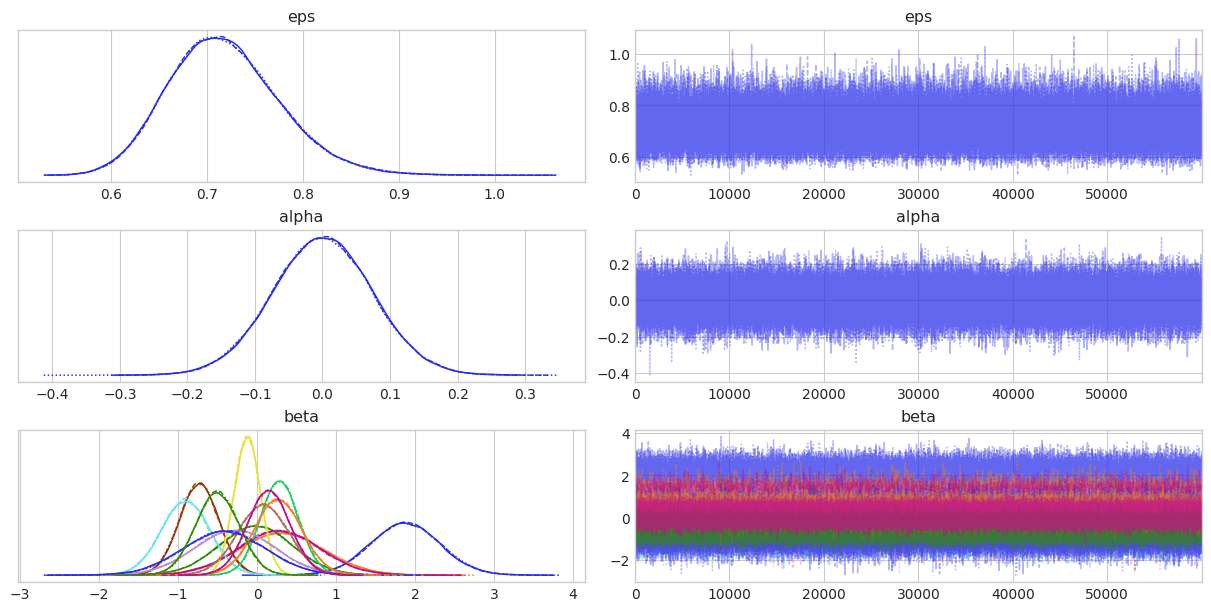

In [33]:
# Plot traces
az.plot_trace(trace, var_names=['eps', 'alpha', 'beta'])
plt.plot()

[]

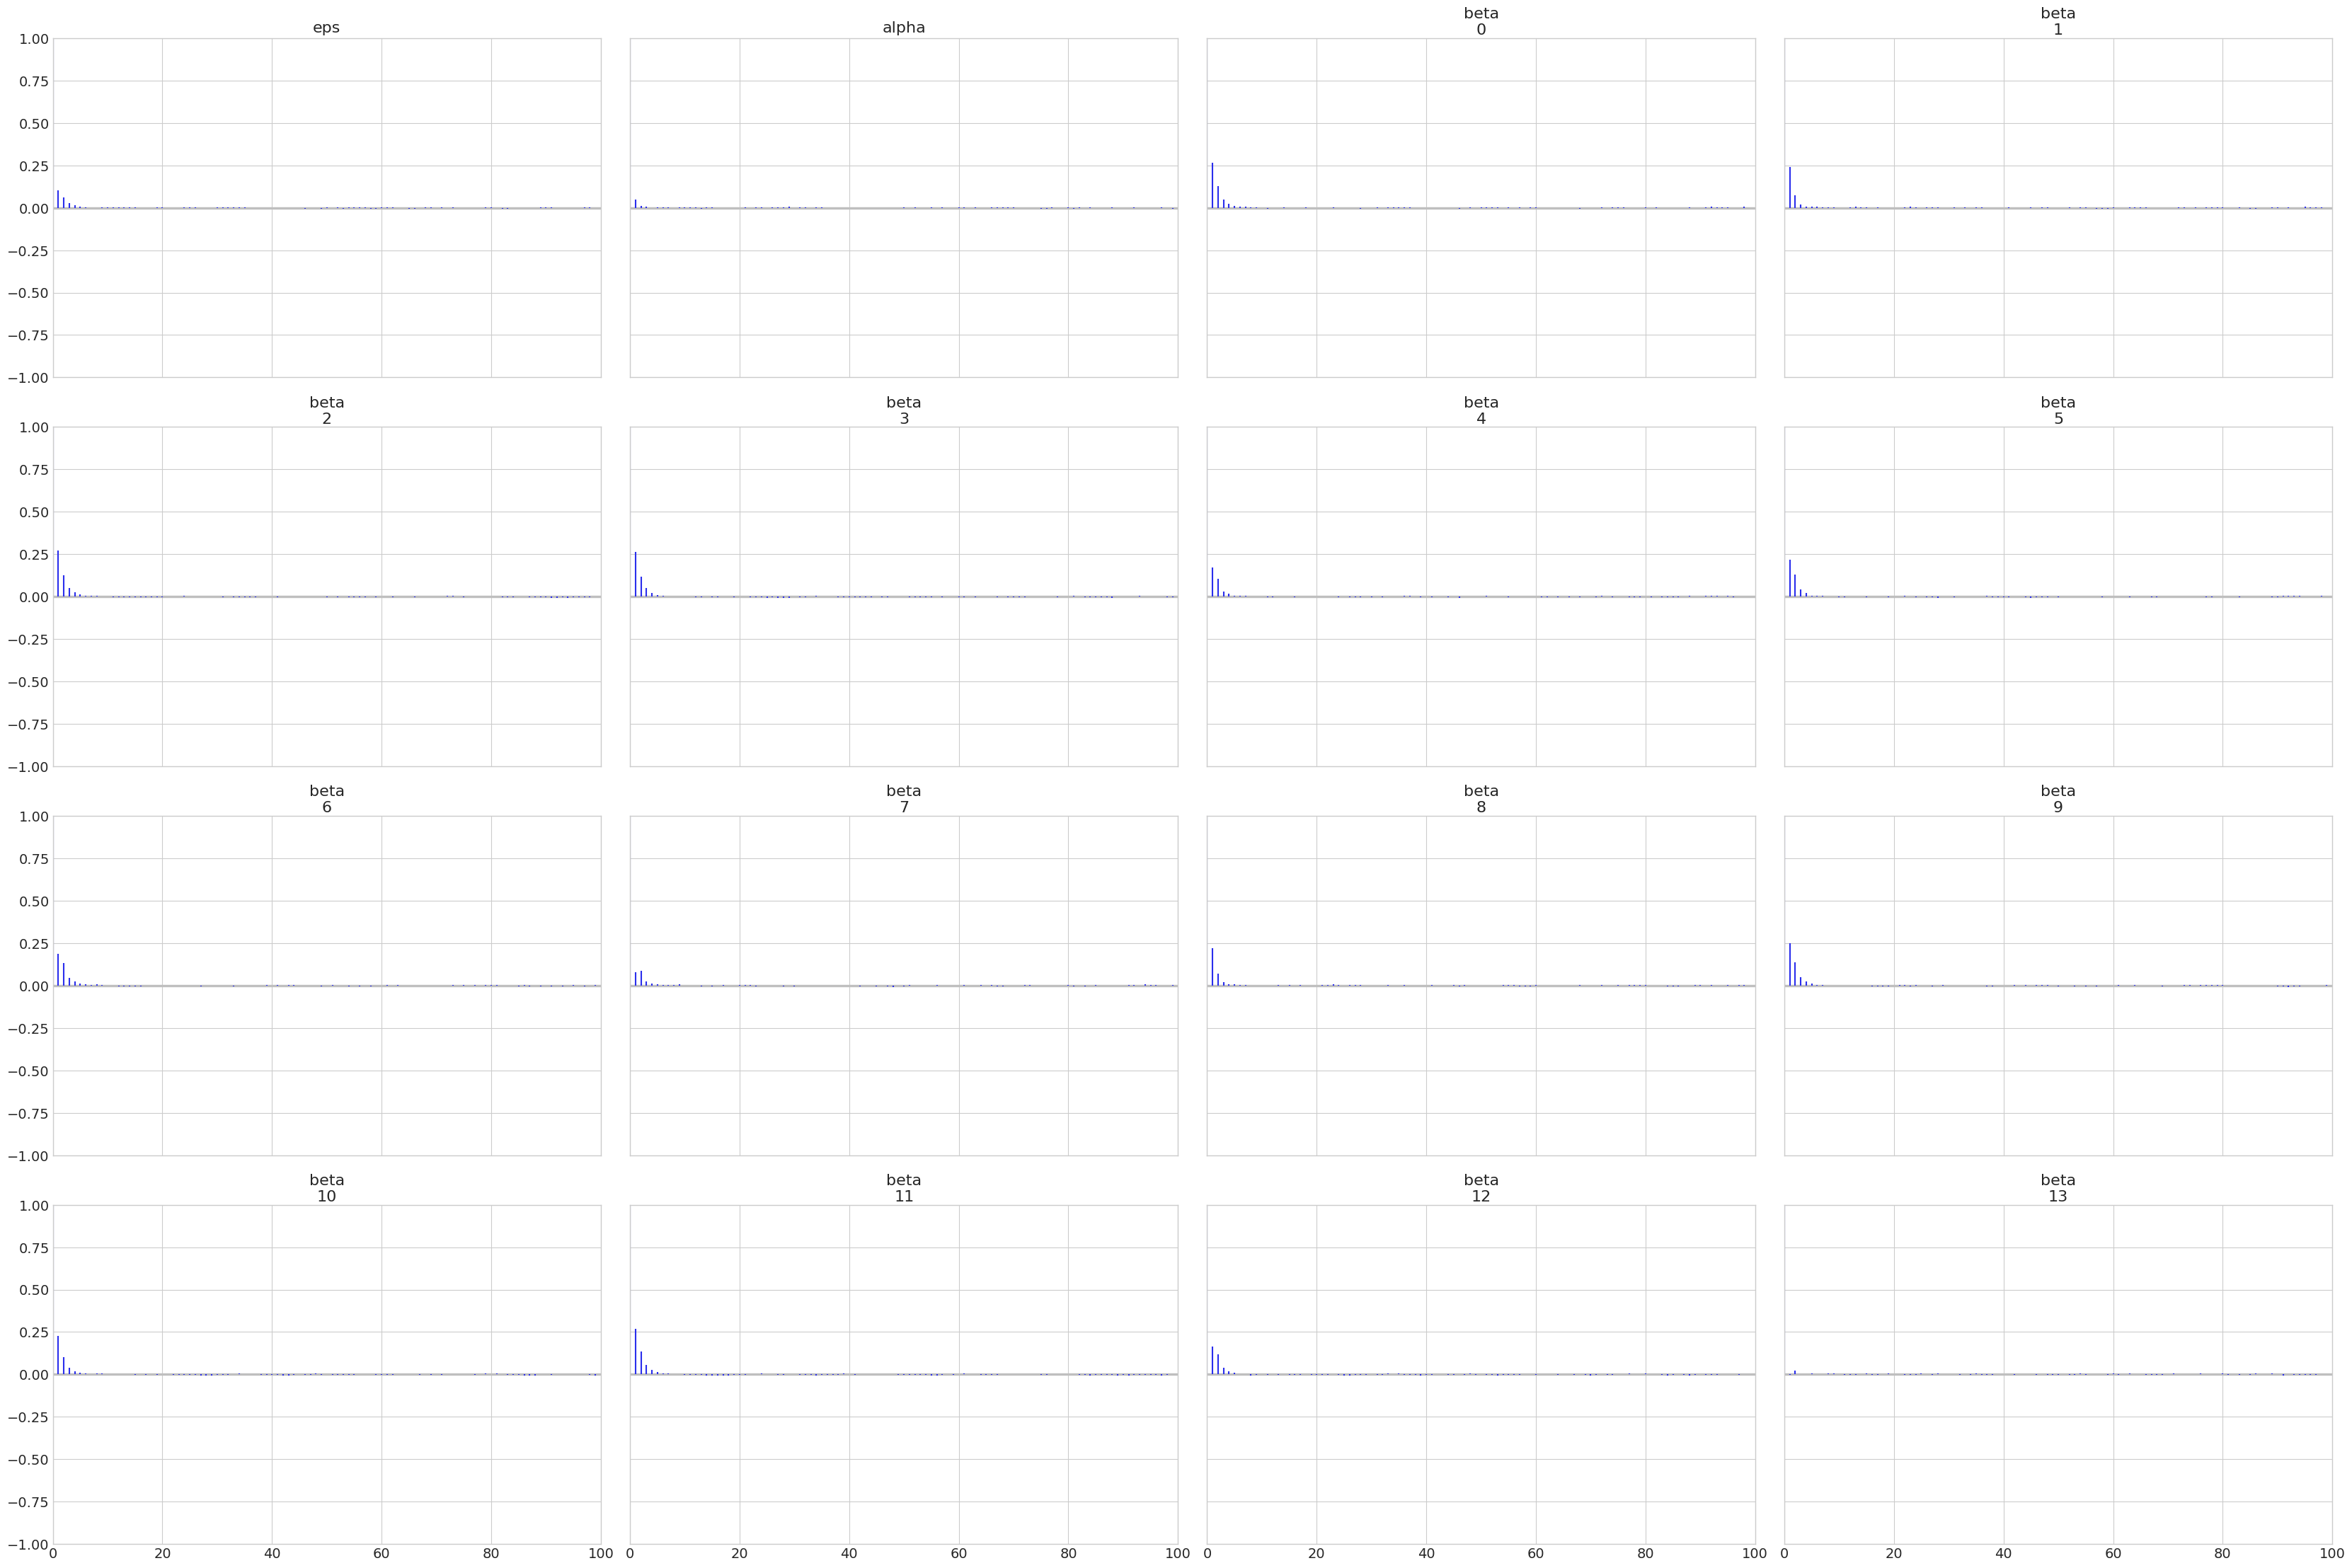

In [34]:
# Plot auto-correlation plots
az.plot_autocorr(trace, var_names=['eps', 'alpha', 'beta'], combined=True)
plt.plot()

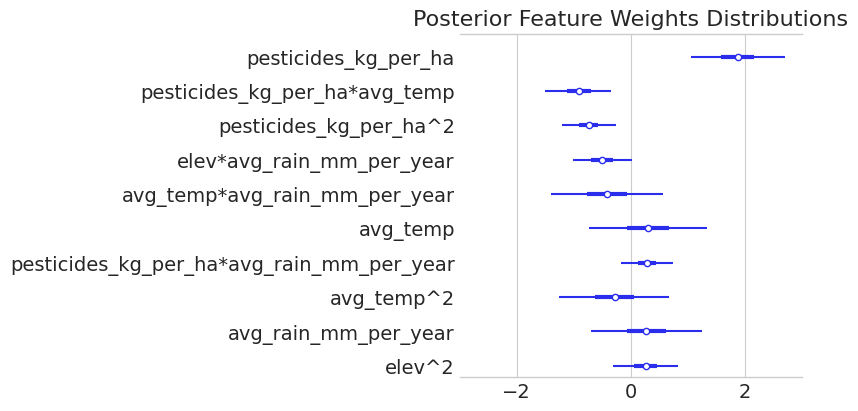

In [35]:
# Plot posterior feature weights distributions
plot_weights_relevance(trace, p_dataset.columns, max_num=10, xlim=(-3, 3))

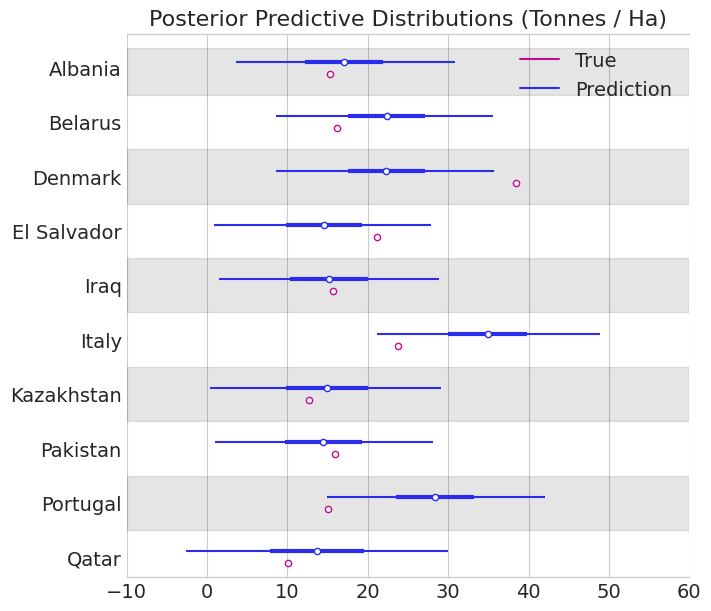

In [36]:
# Sample the predictions and plot them
ppc, pred_samples = pymc3_sample_predictions(model, trace)
pred_samples = y_stddev * pred_samples + y_mean
plot_predictions(
    pred_samples, y_data, test_indices, sample_ids=countries, transform=lambda x: 1e-4 * x,
    xlim=(-10, 60), title='Posterior Predictive Distributions (Tonnes / Ha)'
)

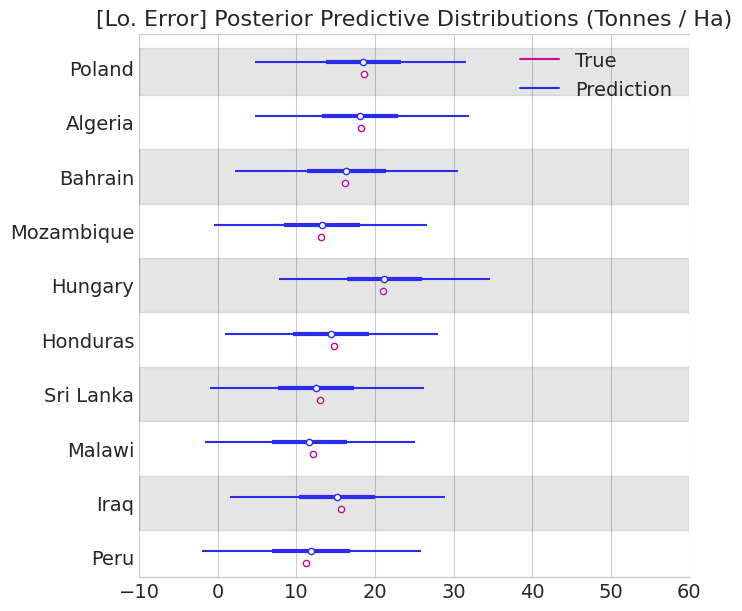

In [37]:
# Sort the predictions by taking the countries having lowest error
lo_err_indices = plot_relevant_predictions(
    pred_samples, y_data, err_descending=False, sample_ids=countries, transform=lambda x: 1e-4 * x,
    xlim=(-10, 60), title='[Lo. Error] Posterior Predictive Distributions (Tonnes / Ha)'
)

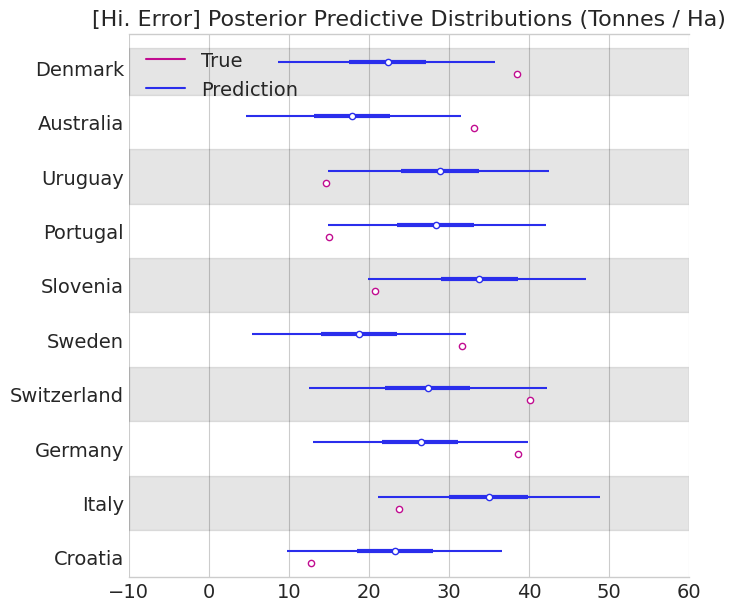

In [38]:
# Sort the predictions by taking the countries having highest error
hi_err_indices = plot_relevant_predictions(
    pred_samples, y_data, err_descending=True, sample_ids=countries, transform=lambda x: 1e-4 * x,
    xlim=(-10, 60), title='[Hi. Error] Posterior Predictive Distributions (Tonnes / Ha)'
)

[]

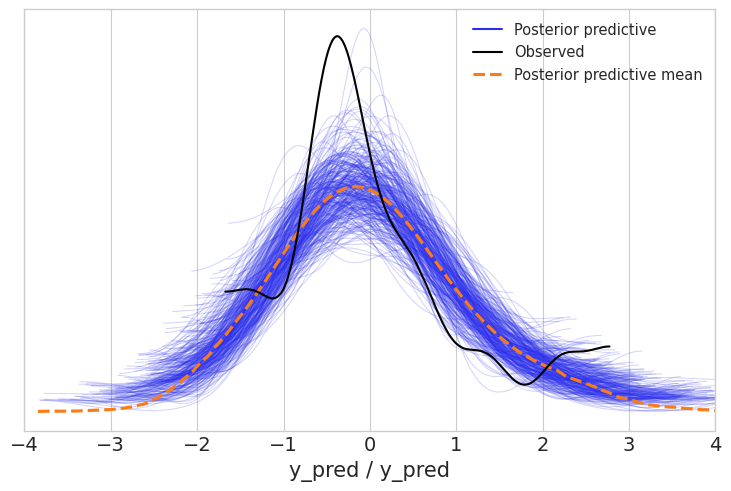

In [39]:
# Posterior predictive check
ppc_data = az.from_pymc3(posterior_predictive=ppc, model=model)
ax = az.plot_ppc(ppc_data, num_pp_samples=320)
ax.set_xlim((-4, 4))
plt.plot()

In [40]:
# Print the average log-likelihood
mu_ll, sigma_ll = compute_average_ll(trace)
print("Quadratic Regression:")
print("Avg. LL: {:.2f} +- {:.2f}".format(mu_ll, sigma_ll))

Quadratic Regression:
Avg. LL: -1.08 +- 0.42


In [41]:
# Print MAE
mae = compute_mae(pred_samples, y_data)
print("Quadratic Regression:")
print("MAE: {:.2f} (Tonnes / Ha)".format(mae * 1e-4))

Quadratic Regression:
MAE: 4.88 (Tonnes / Ha)


In [42]:
# Save results
results['quadratic'] = {
    'metrics': {'ll': (mu_ll, sigma_ll), 'mae': mae},
    'ppc_data': ppc_data,
    'pred_samples': pred_samples,
    'err_indices': (lo_err_indices, hi_err_indices)
}

### Comparison

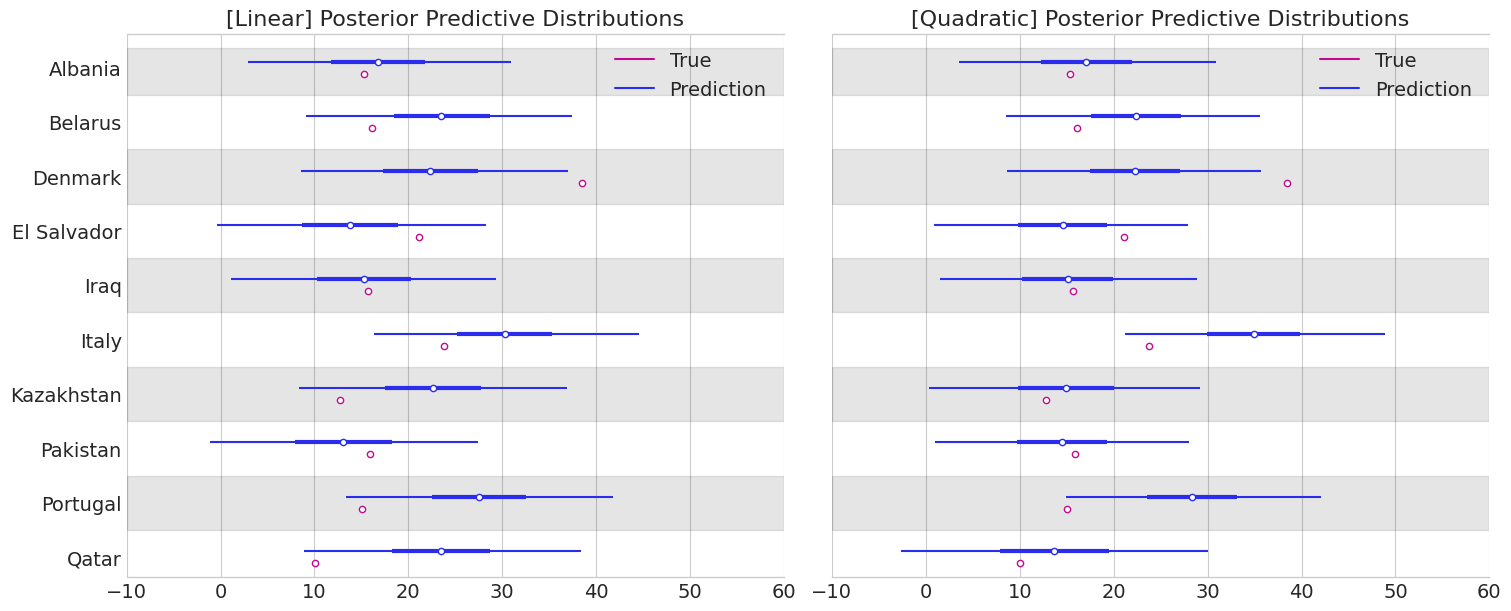

In [43]:
# Plot comparison of predictions
plot_predictions_compare(
    results['linear']['pred_samples'], results['quadratic']['pred_samples'], y_data, test_indices, sample_ids=countries, transform=lambda x: 1e-4 * x,
    xlim=(-10, 60), titles=('[Linear] Posterior Predictive Distributions', '[Quadratic] Posterior Predictive Distributions')
)

[]

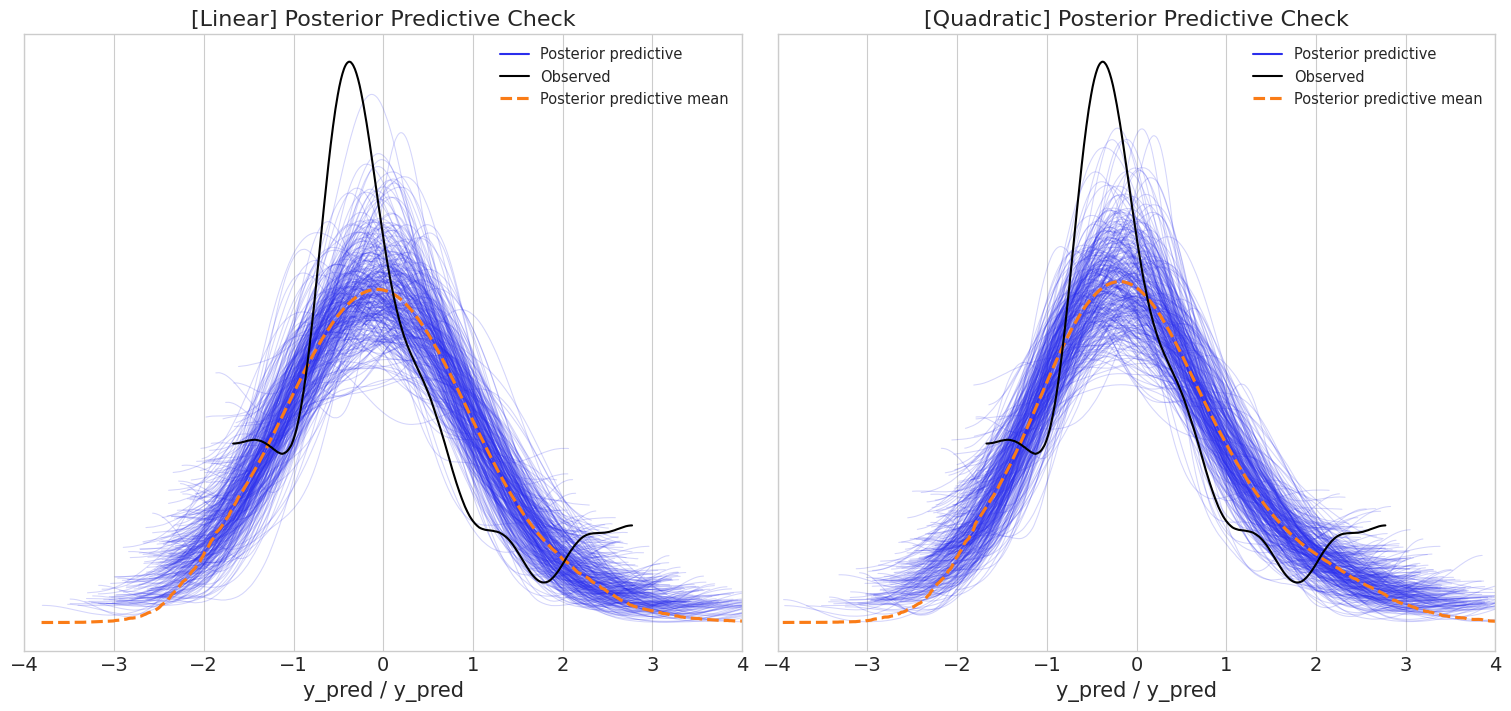

In [44]:
# Posterior predictive check comparison
fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)
az.plot_ppc(results['linear']['ppc_data'], num_pp_samples=320, ax=ax[0])
az.plot_ppc(results['quadratic']['ppc_data'], num_pp_samples=320, ax=ax[1])
ax[0].set_xlim((-4, 4)); ax[1].set_xlim((-4, 4))
ax[0].set_title('[Linear] Posterior Predictive Check'); ax[1].set_title('[Quadratic] Posterior Predictive Check')
plt.plot()

## Removing Outliers (based on Low Pesticides Usage)

The distribution of pesticides usage is really skewed towards a very low usage of them.
We hypothesize that some countries _understimate_ the amount of pesticides used for their crops.
For this reason, we try to remove them from our data, since they can be viewed as outliers.

In [45]:
# Load the dataset
cy = pd.read_csv('data/yield_processed.csv', index_col=0)

# Select Potatoes as item, remove first quartile (based on pesticides), and remove country name feature
cyp = cy[cy['Item'] == 'Potatoes'].drop(columns='Item').reset_index(drop=True)
filter_indices = cyp['pesticides_kg_per_ha'] > cyp['pesticides_kg_per_ha'].quantile(0.25)
cyp = cyp[filter_indices].reset_index(drop=True)
countries = cyp['Area'].unique()
cyp = cyp.drop('Area', axis=1)

### Features Standardization

In [46]:
# Get the features and the target feature
x_data = cyp.drop('hg/ha_yield', axis=1)
y_data = cyp['hg/ha_yield']
cyp.describe()

hg/ha_yield  avg_rain_mm_per_year  pesticides_kg_per_ha   avg_temp  \
count      71.000000             71.000000             71.000000  71.000000   
mean   209207.604397            992.732394              4.171597  15.935264   
std     92567.323537            674.342303              4.216158   7.166818   
min     75126.304348             51.000000              0.227468   3.459565   
25%    144101.136646            590.000000              1.170934   9.519824   
50%    182060.304348            703.000000              2.737318  16.376957   
75%    245124.804348           1449.500000              6.262172  21.351196   
max    448891.538462           3240.000000             20.888427  27.912609   

             lat         lon         elev  
count  71.000000   71.000000    71.000000  
mean   26.853878   11.358560   590.591549  
std    27.552086   57.150321   538.407243  
min   -41.000000 -102.000000    28.000000  
25%    14.416667   -4.500000   245.500000  
50%    33.833333   20.000000   424.000000  
75%    47.166667   35.416667   781.000000  
max    64.000000  174.000000  3186.000000

In [47]:
# Set random seed
np.random.seed(42)

# Standardize the data
x_std_data, x_mean, x_stddev = standardize_data(x_data)
y_std_data, y_mean, y_stddev = standardize_data(y_data)

# Set the indices of the samples that will be used for evaluation
num_test_results = 10
test_indices = np.random.choice(len(y_data), size=num_test_results, replace=False)
test_indices = np.sort(test_indices)

### Full Quadratic Regression

In [48]:
# Build design matrix for polynomial regression with grade 2
features = ['pesticides_kg_per_ha', 'avg_temp', 'elev', 'avg_rain_mm_per_year']
p_dataset = design_matrix_polynomial(x_data[features], n=2)

# Standardize the data
p_dataset, p_mean, p_stddev = standardize_data(p_dataset)
p_dataset.describe()

pesticides_kg_per_ha      avg_temp          elev  avg_rain_mm_per_year  \
count          7.100000e+01  7.100000e+01  7.100000e+01          7.100000e+01   
mean           1.032038e-16  3.236847e-16  6.723886e-17          6.254778e-17   
std            1.007118e+00  1.007118e+00  1.007118e+00          1.007118e+00   
min           -9.421378e-01 -1.753148e+00 -1.052355e+00         -1.406460e+00   
25%           -7.167712e-01 -9.015300e-01 -6.455109e-01         -6.014732e-01   
50%           -3.426077e-01  6.206891e-02 -3.116178e-01         -4.327099e-01   
75%            4.993775e-01  7.610741e-01  3.561685e-01          6.821738e-01   
max            3.993165e+00  1.683117e+00  4.854841e+00          3.356252e+00   

       pesticides_kg_per_ha^2  pesticides_kg_per_ha*avg_temp  \
count            7.100000e+01                   7.100000e+01   
mean            -4.378344e-17                  -1.063312e-16   
std              1.007118e+00                   1.007118e+00   
min             -4.842595e-01                  -9.074526e-01   
25%             -4.659392e-01                  -7.548098e-01   
50%             -3.809379e-01                  -4.430943e-01   
75%              5.952837e-02                   4.871873e-01   
max              5.573475e+00                   3.706031e+00   

       pesticides_kg_per_ha*elev  pesticides_kg_per_ha*avg_rain_mm_per_year  \
count               7.100000e+01                               7.100000e+01   
mean                3.119570e-16                              -6.723886e-17   
std                 1.007118e+00                               1.007118e+00   
min                -7.220809e-01                              -6.596160e-01   
25%                -5.976538e-01                              -5.859129e-01   
50%                -3.944823e-01                              -4.758454e-01   
75%                 1.766784e-01                               3.385747e-01   
max                 5.658560e+00                               4.920491e+00   

         avg_temp^2  avg_temp*elev  avg_temp*avg_rain_mm_per_year  \
count  7.100000e+01   7.100000e+01                   7.100000e+01   
mean  -1.563694e-17  -2.095350e-16                  -1.235319e-16   
std    1.007118e+00   1.007118e+00                   1.007118e+00   
min   -1.225349e+00  -1.145467e+00                  -8.990359e-01   
25%   -8.959322e-01  -9.167363e-01                  -6.834976e-01   
50%   -1.522988e-01  -2.671675e-01                  -4.008038e-01   
75%    6.339531e-01   7.027127e-01                   3.314831e-01   
max    1.987255e+00   2.791475e+00                   3.505316e+00   

             elev^2  elev*avg_rain_mm_per_year  avg_rain_mm_per_year^2  
count  7.100000e+01               7.100000e+01            7.100000e+01  
mean  -1.250956e-17               4.436983e-17           -5.316561e-17  
std    1.007118e+00               1.007118e+00            1.007118e+00  
min   -4.682645e-01              -8.856656e-01           -7.748305e-01  
25%   -4.240896e-01              -7.330461e-01           -5.877883e-01  
50%   -3.360244e-01              -3.394526e-01           -5.086904e-01  
75%   -1.793513e-02               1.757886e-01            3.618819e-01  
max    7.030462e+00               3.357214e+00            4.906810e+00

In [49]:
# Build a PyMC3 model for linear regression
model = pymc3_linear_regression_model(p_dataset, y_std_data)

# Sample from the posterior
with model:
    trace = pm.sample(
        draws=60_000, tune=20_000, target_accept=0.9,
        chains=3, cores=3, random_seed=42,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eps, beta, alpha]


Sampling 3 chains for 20_000 tune and 60_000 draw iterations (60_000 + 180_000 draws total) took 409 seconds.


[]

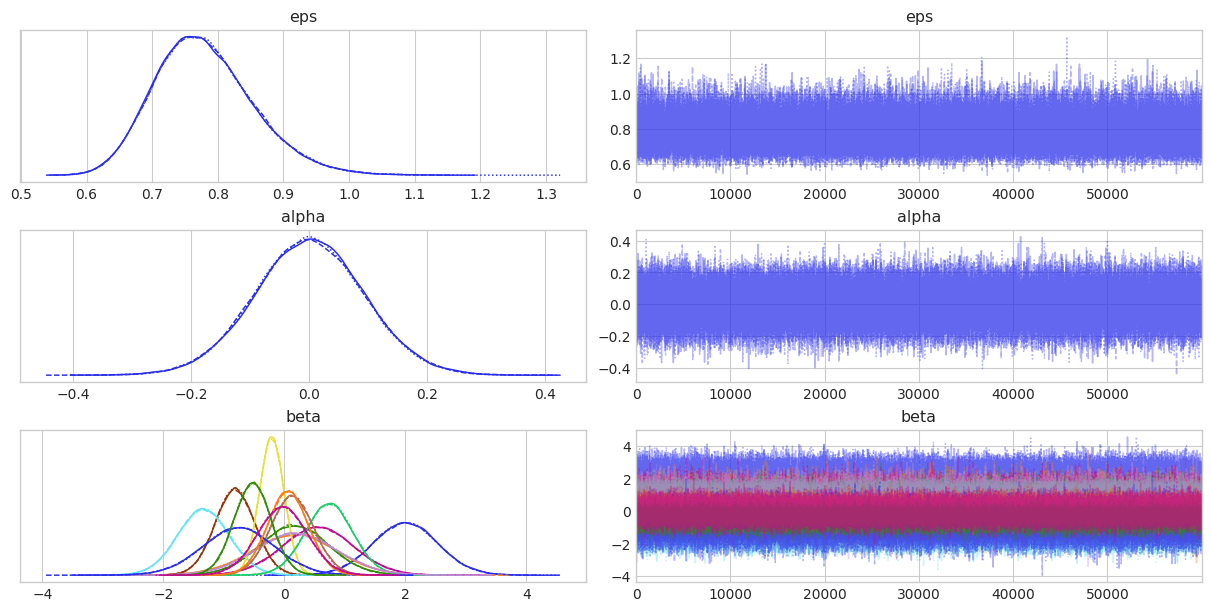

In [50]:
# Plot traces
az.plot_trace(trace, var_names=['eps', 'alpha', 'beta'])
plt.plot()

[]

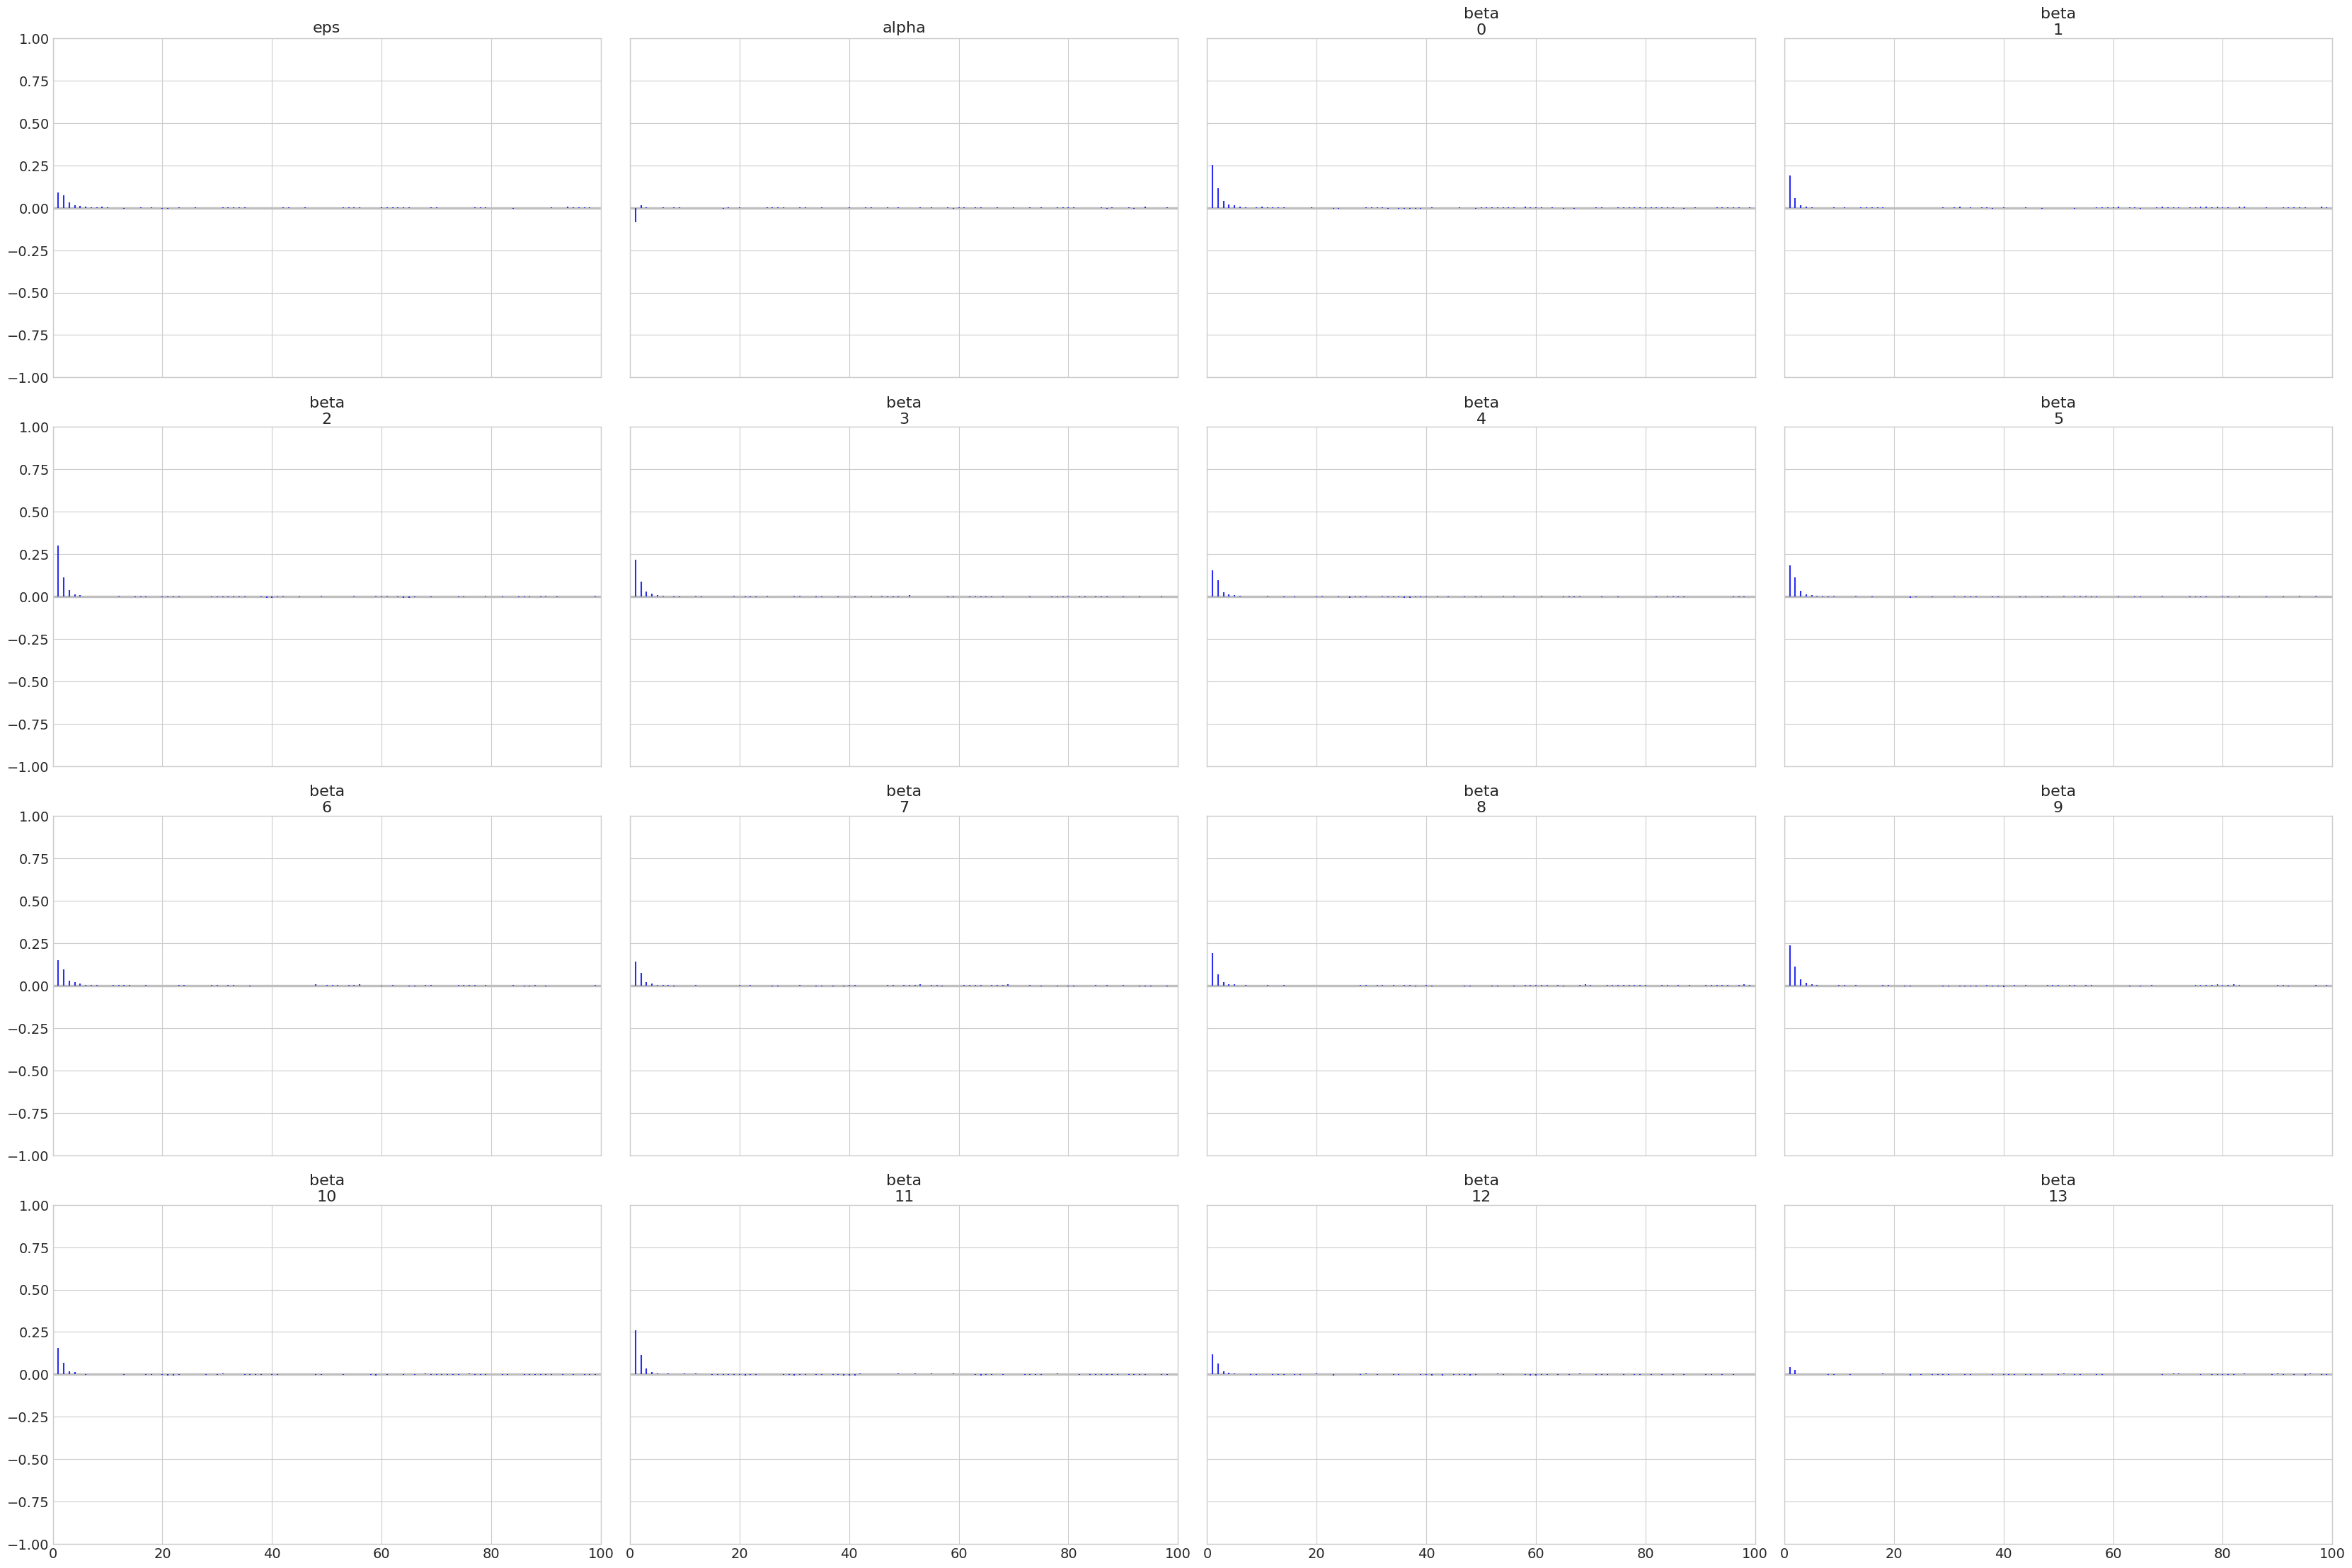

In [51]:
# Plot auto-correlation plots
az.plot_autocorr(trace, var_names=['eps', 'alpha', 'beta'], combined=True)
plt.plot()

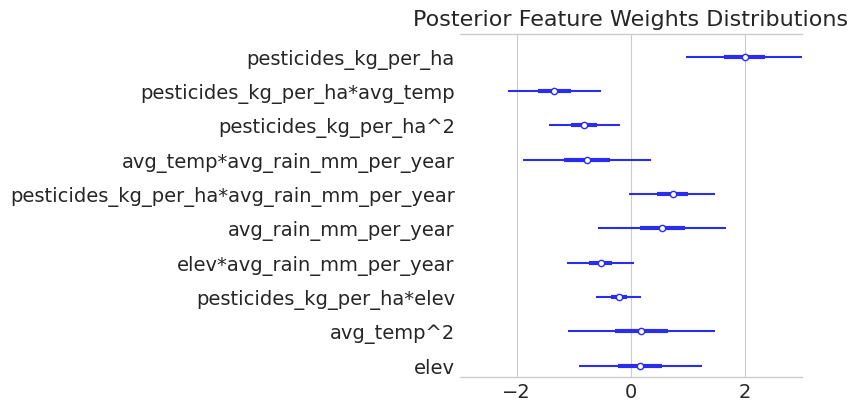

In [52]:
# Plot posterior feature weights distributions
plot_weights_relevance(trace, p_dataset.columns, max_num=10, xlim=(-3, 3))

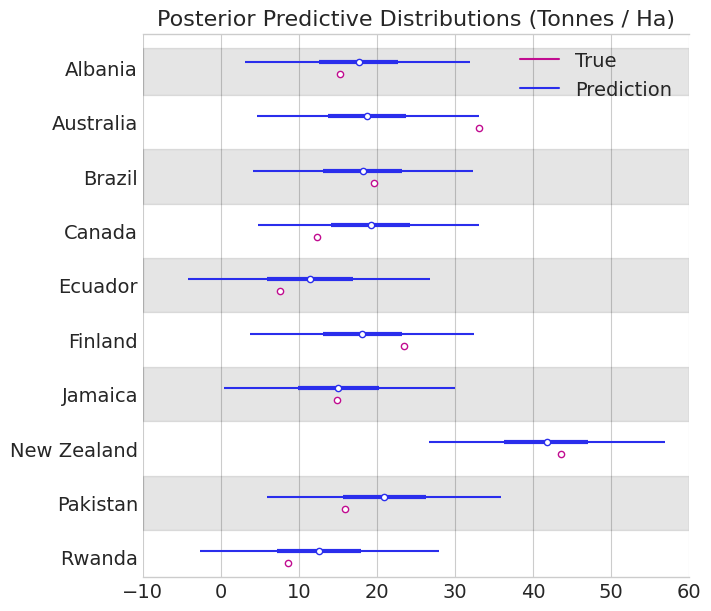

In [53]:
# Sample the predictions and plot them
ppc, pred_samples = pymc3_sample_predictions(model, trace)
pred_samples = y_stddev * pred_samples + y_mean
plot_predictions(
    pred_samples, y_data, test_indices, sample_ids=countries, transform=lambda x: 1e-4 * x,
    xlim=(-10, 60), title='Posterior Predictive Distributions (Tonnes / Ha)'
)

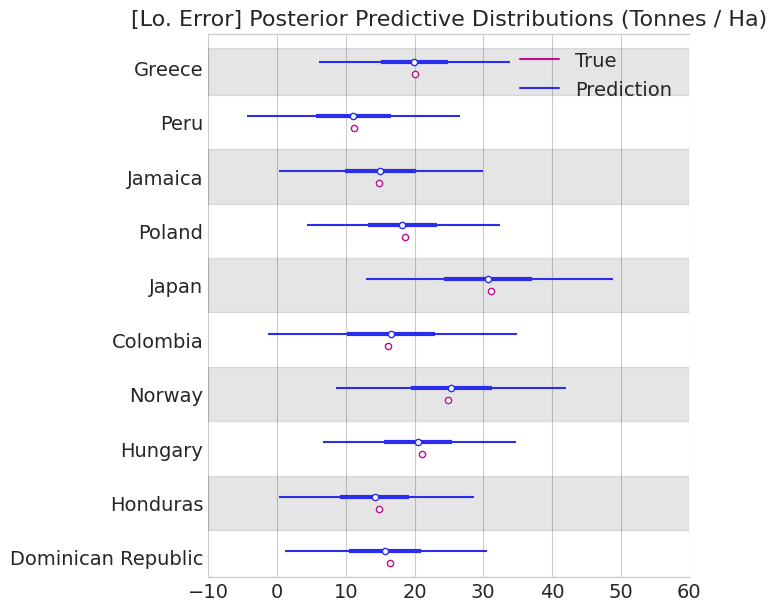

In [54]:
# Sort the predictions by taking the countries having lowest error
lo_err_indices = plot_relevant_predictions(
    pred_samples, y_data, err_descending=False, sample_ids=countries, transform=lambda x: 1e-4 * x,
    xlim=(-10, 60), title='[Lo. Error] Posterior Predictive Distributions (Tonnes / Ha)'
)

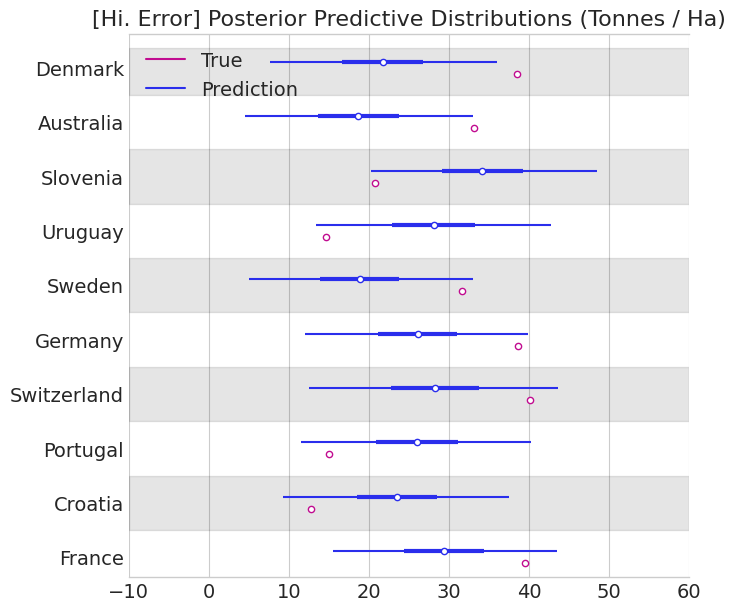

In [55]:
# Sort the predictions by taking the countries having highest error
hi_err_indices = plot_relevant_predictions(
    pred_samples, y_data, err_descending=True, sample_ids=countries, transform=lambda x: 1e-4 * x,
    xlim=(-10, 60), title='[Hi. Error] Posterior Predictive Distributions (Tonnes / Ha)'
)

[]

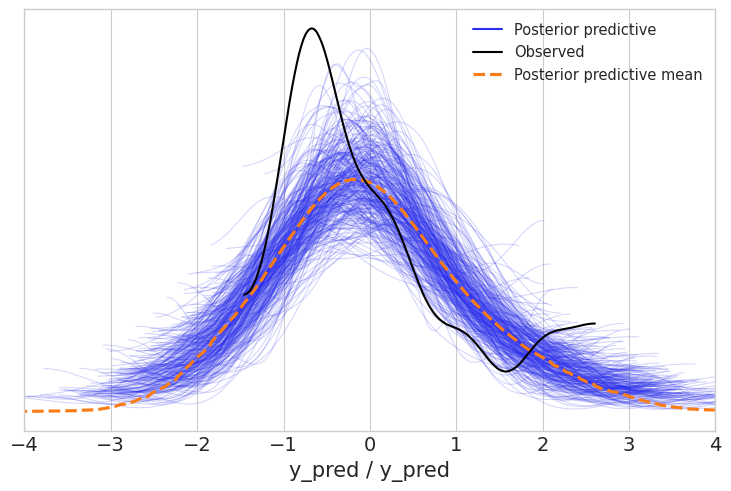

In [56]:
# Posterior predictive check
ppc_data = az.from_pymc3(posterior_predictive=ppc, model=model)
ax = az.plot_ppc(ppc_data, num_pp_samples=320)
ax.set_xlim((-4, 4))
plt.plot()

In [57]:
# Print the average log-likelihood
mu_ll, sigma_ll = compute_average_ll(trace)
print("Quadratic Regression without Outliers:")
print("Avg. LL: {:.2f} +- {:.2f}".format(mu_ll, sigma_ll))

Quadratic Regression without Outliers:
Avg. LL: -1.16 +- 0.46


In [58]:
# Print MAE
mae = compute_mae(pred_samples, y_data)
print("Quadratic Regression without Outliers:")
print("MAE: {:.2f} (Tonnes / Ha)".format(mae * 1e-4))

Quadratic Regression without Outliers:
MAE: 4.76 (Tonnes / Ha)


In [59]:
# Save results
results['quadratic_wo'] = {
    'metrics': {'ll': (mu_ll, sigma_ll), 'mae': mae},
    'ppc_data': ppc_data,
    'pred_samples': pred_samples,
    'err_indices': (lo_err_indices, hi_err_indices)
}

### Comparison

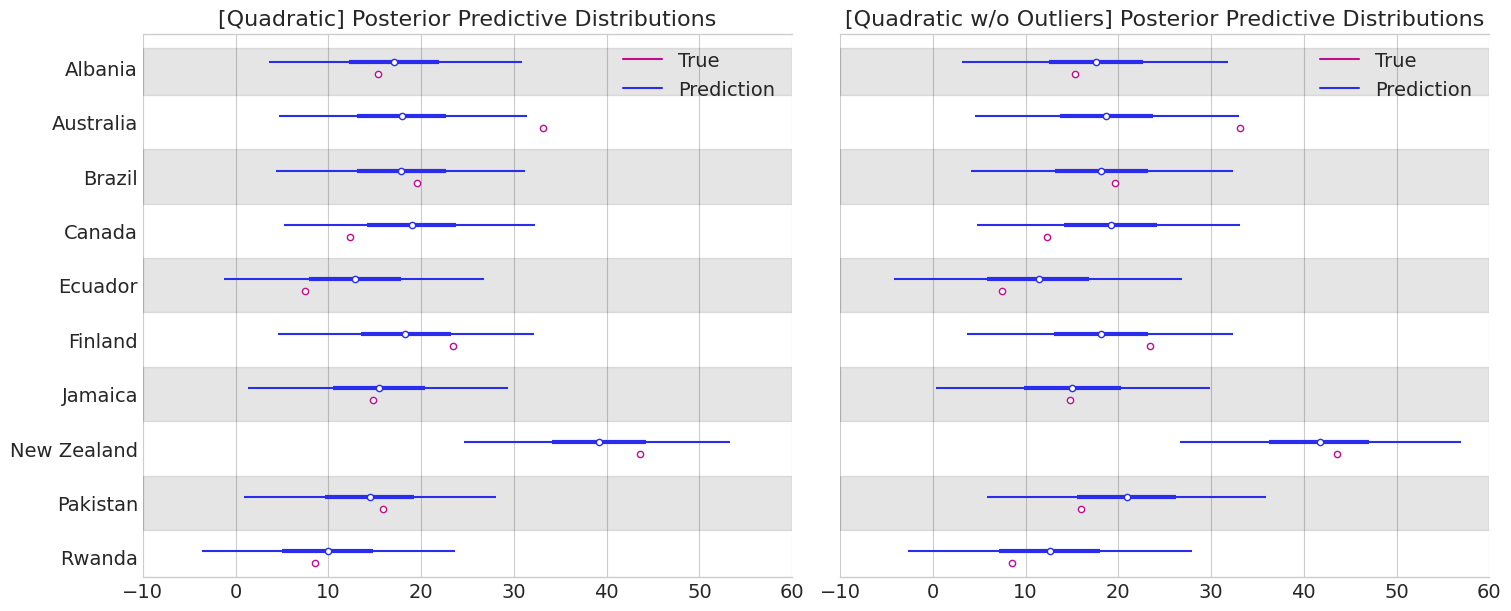

In [60]:
# Plot comparison of predictions
plot_predictions_compare(
    results['quadratic']['pred_samples'][:, filter_indices], results['quadratic_wo']['pred_samples'], y_data, test_indices, sample_ids=countries, transform=lambda x: 1e-4 * x,
    xlim=(-10, 60), titles=('[Quadratic] Posterior Predictive Distributions', '[Quadratic w/o Outliers] Posterior Predictive Distributions')
)

[]

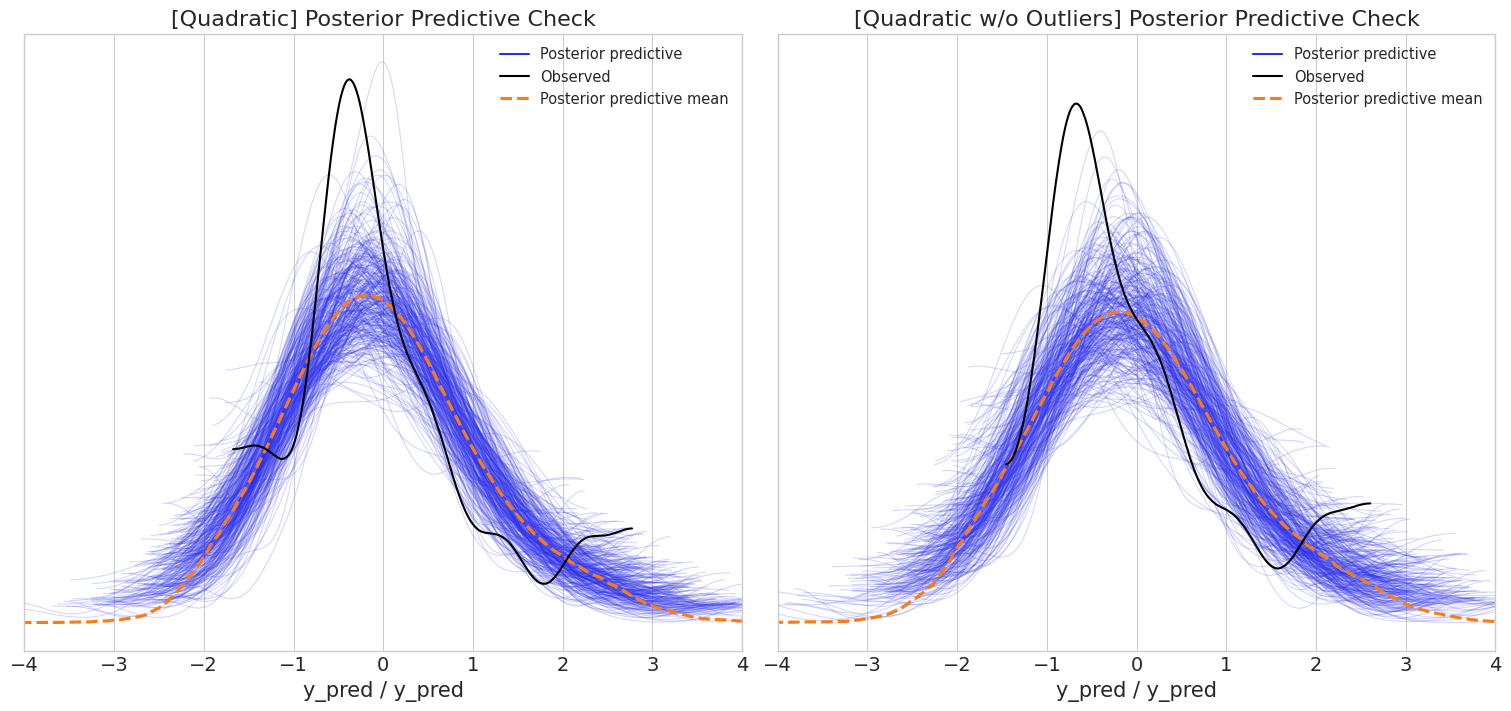

In [61]:
# Posterior predictive check comparison
fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)
az.plot_ppc(results['quadratic']['ppc_data'], num_pp_samples=320, ax=ax[0])
az.plot_ppc(results['quadratic_wo']['ppc_data'], num_pp_samples=320, ax=ax[1])
ax[0].set_xlim((-4, 4)); ax[1].set_xlim((-4, 4))
ax[0].set_title('[Quadratic] Posterior Predictive Check'); ax[1].set_title('[Quadratic w/o Outliers] Posterior Predictive Check')
plt.plot()

# Regression with Variable Variance

Until now, we assumed that the prior of the variance $\epsilon$ is a _constant distribution_, i.e. its hyper-parameters does not depend on other variables in our model.

$$\epsilon \sim |\mathcal{C}(0,\tau_\epsilon)|$$

However, in some cases we might be interested in _injecting knowledge_ in our model about uncertainty.
Specifically for regression models, this can be done by modeling the variance $\epsilon$, in a similar way as we did for the mean $\mu$.

$$\log \epsilon = \gamma + \sum_{i=1}^M \delta_i B_i(X)$$

$$y\sim \mathcal{N}(\mu,\epsilon)$$

where $\gamma$ and $\delta_i$ are the parameters of the model, and $B_i(x)$ are the _basis functions_.

In [62]:
def pymc3_linear_regression_variance_model(
    x_data, y_data, v_data,
    alpha_mu=0.0, alpha_sd=8.0,
    beta_mu=0.0, beta_sd=8.0
):
    # Build a PyMC3 linear regression model with variable variance
    with pm.Model() as model:
        # Intercept and slope priors for mu
        alpha = pm.Normal('alpha', mu=alpha_mu, sd=alpha_sd)
        beta = pm.Normal('beta', mu=beta_mu, sd=beta_sd, shape=x_data.shape[1])

        # Intercept and slope priors for eps
        gamma = pm.Normal('gamma', mu=0.0, sd=1.0)
        delta = pm.Normal('delta', mu=0.0, sd=1.0, shape=v_data.shape[1])

        # Likelihood
        mu = pm.Deterministic('mu', alpha + tt.dot(x_data, beta))
        eps = pm.Deterministic('eps', tt.clip(tt.exp(gamma + tt.dot(v_data, delta)), 2e-4, 2e1))
        y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y_data)
        return model

## Quadratic Regression with Variable Variance with PyMC3

In [63]:
# Load the dataset
cy = pd.read_csv('data/yield_processed.csv', index_col=0)

# Select Potatoes as item and remove country name feature
cyp = cy[cy['Item'] == 'Potatoes'].drop(columns='Item').reset_index(drop=True)
countries = cyp['Area'].unique()
cyp = cyp.drop('Area', axis=1)

# Get the features and the target feature
x_data = cyp.drop('hg/ha_yield', axis=1)
y_data = cyp['hg/ha_yield']

# Set random seed
np.random.seed(42)

# Standardize the data
x_std_data, x_mean, x_stddev = standardize_data(x_data)
y_std_data, y_mean, y_stddev = standardize_data(y_data)

# Set the indices of the samples that will be used for evaluation
num_test_results = 10
test_indices = np.random.choice(len(y_data), size=num_test_results, replace=False)
test_indices = np.sort(test_indices)
cyp.describe()

hg/ha_yield  avg_rain_mm_per_year  pesticides_kg_per_ha   avg_temp  \
count      95.000000             95.000000             95.000000  95.000000   
mean   181841.413334           1019.326316              3.143013  17.850083   
std     96668.731420            696.800613              4.049940   7.388661   
min     20516.217391             51.000000              0.003028   3.459565   
25%    127517.738095            577.000000              0.217843  10.646667   
50%    160965.434783            788.000000              1.590888  18.163478   
75%    224914.108696           1492.500000              4.085821  24.843652   
max    448891.538462           3240.000000             20.888427  29.718696   

             lat         lon         elev  
count  95.000000   95.000000    95.000000  
mean   21.398688   15.279380   637.568421  
std    27.141268   54.357624   586.573509  
min   -41.000000 -102.000000    28.000000  
25%     2.500000   -3.000000   297.500000  
50%    25.000000   20.000000   460.000000  
75%    44.083333   35.416667   826.500000  
max    64.000000  174.000000  3265.000000

In [64]:
# Build design matrix for polynomial regression with grade 2
features = ['pesticides_kg_per_ha', 'avg_temp', 'elev', 'avg_rain_mm_per_year']
p_dataset = design_matrix_polynomial(x_data[features], n=2)

# Standardize the data
p_dataset, p_mean, p_stddev = standardize_data(p_dataset)
p_dataset.describe()

pesticides_kg_per_ha      avg_temp          elev  avg_rain_mm_per_year  \
count          9.500000e+01  9.500000e+01  9.500000e+01          9.500000e+01   
mean          -4.090295e-18  1.110223e-16 -3.856564e-17         -2.571043e-17   
std            1.005305e+00  1.005305e+00  1.005305e+00          1.005305e+00   
min           -7.794295e-01 -1.957981e+00 -1.044715e+00         -1.397047e+00   
25%           -7.261067e-01 -9.801006e-01 -5.828298e-01         -6.381637e-01   
50%           -3.852796e-01  4.264066e-02 -3.043275e-01         -3.337447e-01   
75%            2.340307e-01  9.515486e-01  3.238023e-01          6.826686e-01   
max            4.404894e+00  1.614850e+00  4.503051e+00          3.203864e+00   

       pesticides_kg_per_ha^2  pesticides_kg_per_ha*avg_temp  \
count            9.500000e+01                   9.500000e+01   
mean            -5.901712e-17                  -5.843279e-19   
std              1.005305e+00                   1.005305e+00   
min             -4.074095e-01                  -7.475924e-01   
25%             -4.066677e-01                  -6.753082e-01   
50%             -3.679150e-01                  -4.538798e-01   
75%             -1.468989e-01                   3.014929e-01   
max              6.401398e+00                   4.139688e+00   

       pesticides_kg_per_ha*elev  pesticides_kg_per_ha*avg_rain_mm_per_year  \
count               9.500000e+01                               9.500000e+01   
mean                1.679943e-16                               7.187233e-17   
std                 1.005305e+00                               1.005305e+00   
min                -6.040307e-01                              -5.524163e-01   
25%                -5.633282e-01                              -5.222205e-01   
50%                -4.182575e-01                              -4.369116e-01   
75%                 1.543385e-01                               1.175884e-01   
max                 6.359600e+00                               5.588190e+00   

         avg_temp^2  avg_temp*elev  avg_temp*avg_rain_mm_per_year  \
count  9.500000e+01   9.500000e+01                   9.500000e+01   
mean  -3.783523e-16  -1.659491e-16                   7.713128e-17   
std    1.005305e+00   1.005305e+00                   1.005305e+00   
min   -1.399833e+00  -1.174473e+00                  -9.739432e-01   
25%   -1.006351e+00  -7.864306e-01                  -7.352445e-01   
50%   -1.658463e-01  -2.304064e-01                  -4.156088e-01   
75%    9.492200e-01   5.917745e-01                   4.242161e-01   
max    1.981553e+00   4.212664e+00                   3.218028e+00   

             elev^2  elev*avg_rain_mm_per_year  avg_rain_mm_per_year^2  
count  9.500000e+01               9.500000e+01            9.500000e+01  
mean   1.007966e-17               1.877153e-17            4.440892e-17  
std    1.005305e+00               1.005305e+00            1.005305e+00  
min   -4.574500e-01              -8.550837e-01           -7.687729e-01  
25%   -4.036695e-01              -7.068100e-01           -6.012819e-01  
50%   -3.282039e-01              -3.231122e-01           -4.553821e-01  
75%   -3.870694e-02               2.230270e-01            3.589152e-01  
max    6.077591e+00               5.379781e+00            4.550339e+00

The information we have about pesticides is related to the average usage of pesticides per country independently of the crops where they are effectively used.
So, we can suppose that the usage of pesticides in a country is somewhat related to the amount of uncertainty in our models, since we are unsure about the effects of the usage of pesticides in a country precisely for the chosen crop type.

However, we transform the pesticides usage feature to be in logarithm space in order to reduce the impact on the variance of very high values (due to the skewness of its distribution).

In [65]:
# Set the dataset for variable variance
log_pesticides = np.log(1.0 + x_data['pesticides_kg_per_ha'])
v_dataset = pd.DataFrame({
    'log_pesticides_kg_per_ha': log_pesticides,
    'log_pesticides_kg_per_ha^2': log_pesticides ** 2,
})
v_dataset, v_mean, v_stddev = standardize_data(v_dataset)
v_dataset.describe()

log_pesticides_kg_per_ha  log_pesticides_kg_per_ha^2
count              9.500000e+01                9.500000e+01
mean               6.310741e-17                6.895069e-17
std                1.005305e+00                1.005305e+00
min               -1.265291e+00               -8.287694e-01
25%               -1.031689e+00               -8.108739e-01
50%               -1.227498e-01               -4.116441e-01
75%                6.892689e-01                3.887583e-01
max                2.446473e+00                3.554278e+00

In [66]:
# Build a PyMC3 model for linear regression with variable variance
model = pymc3_linear_regression_variance_model(p_dataset, y_std_data, v_dataset)

# Sample from the posterior
with model:
    trace = pm.sample(
        draws=60_000, tune=20_000, target_accept=0.95,
        chains=3, cores=3, random_seed=42,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [delta, gamma, beta, alpha]


Sampling 3 chains for 20_000 tune and 60_000 draw iterations (60_000 + 180_000 draws total) took 703 seconds.


[]

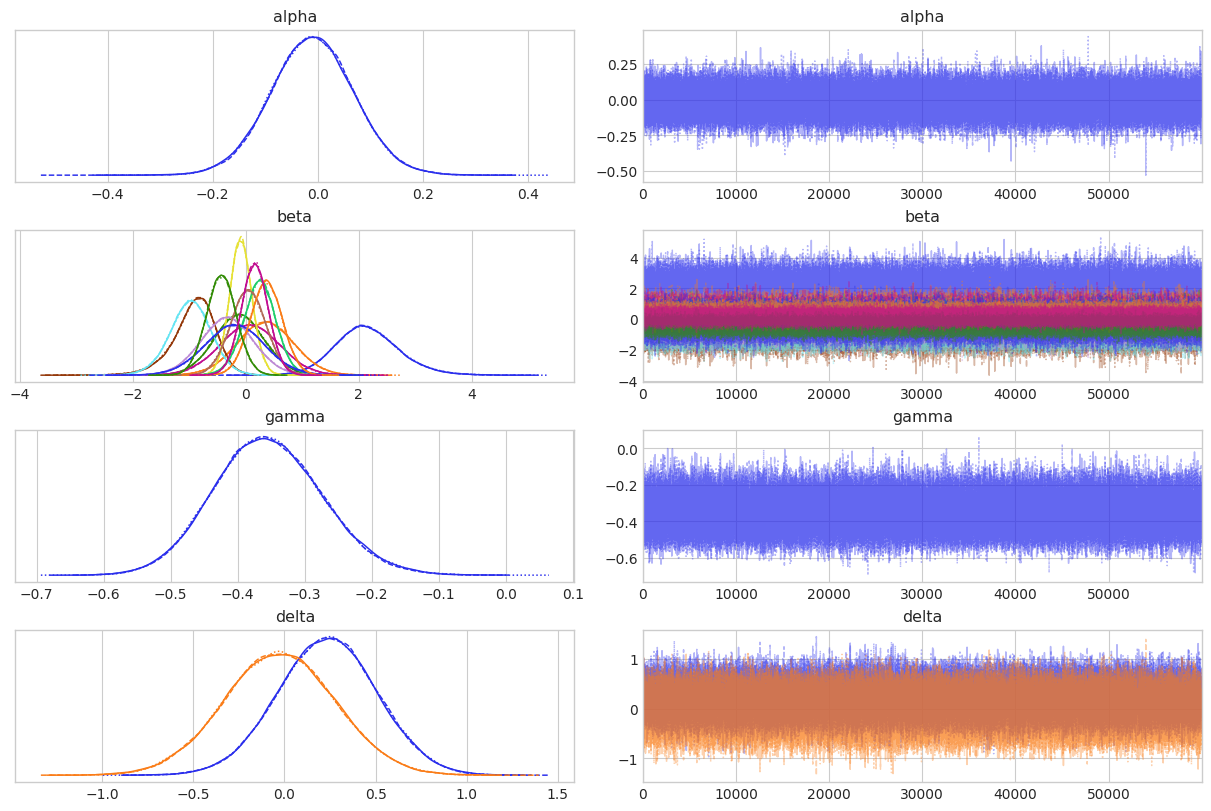

In [67]:
# Plot traces
az.plot_trace(trace, var_names=['alpha', 'beta', 'gamma', 'delta'])
plt.plot()

[]

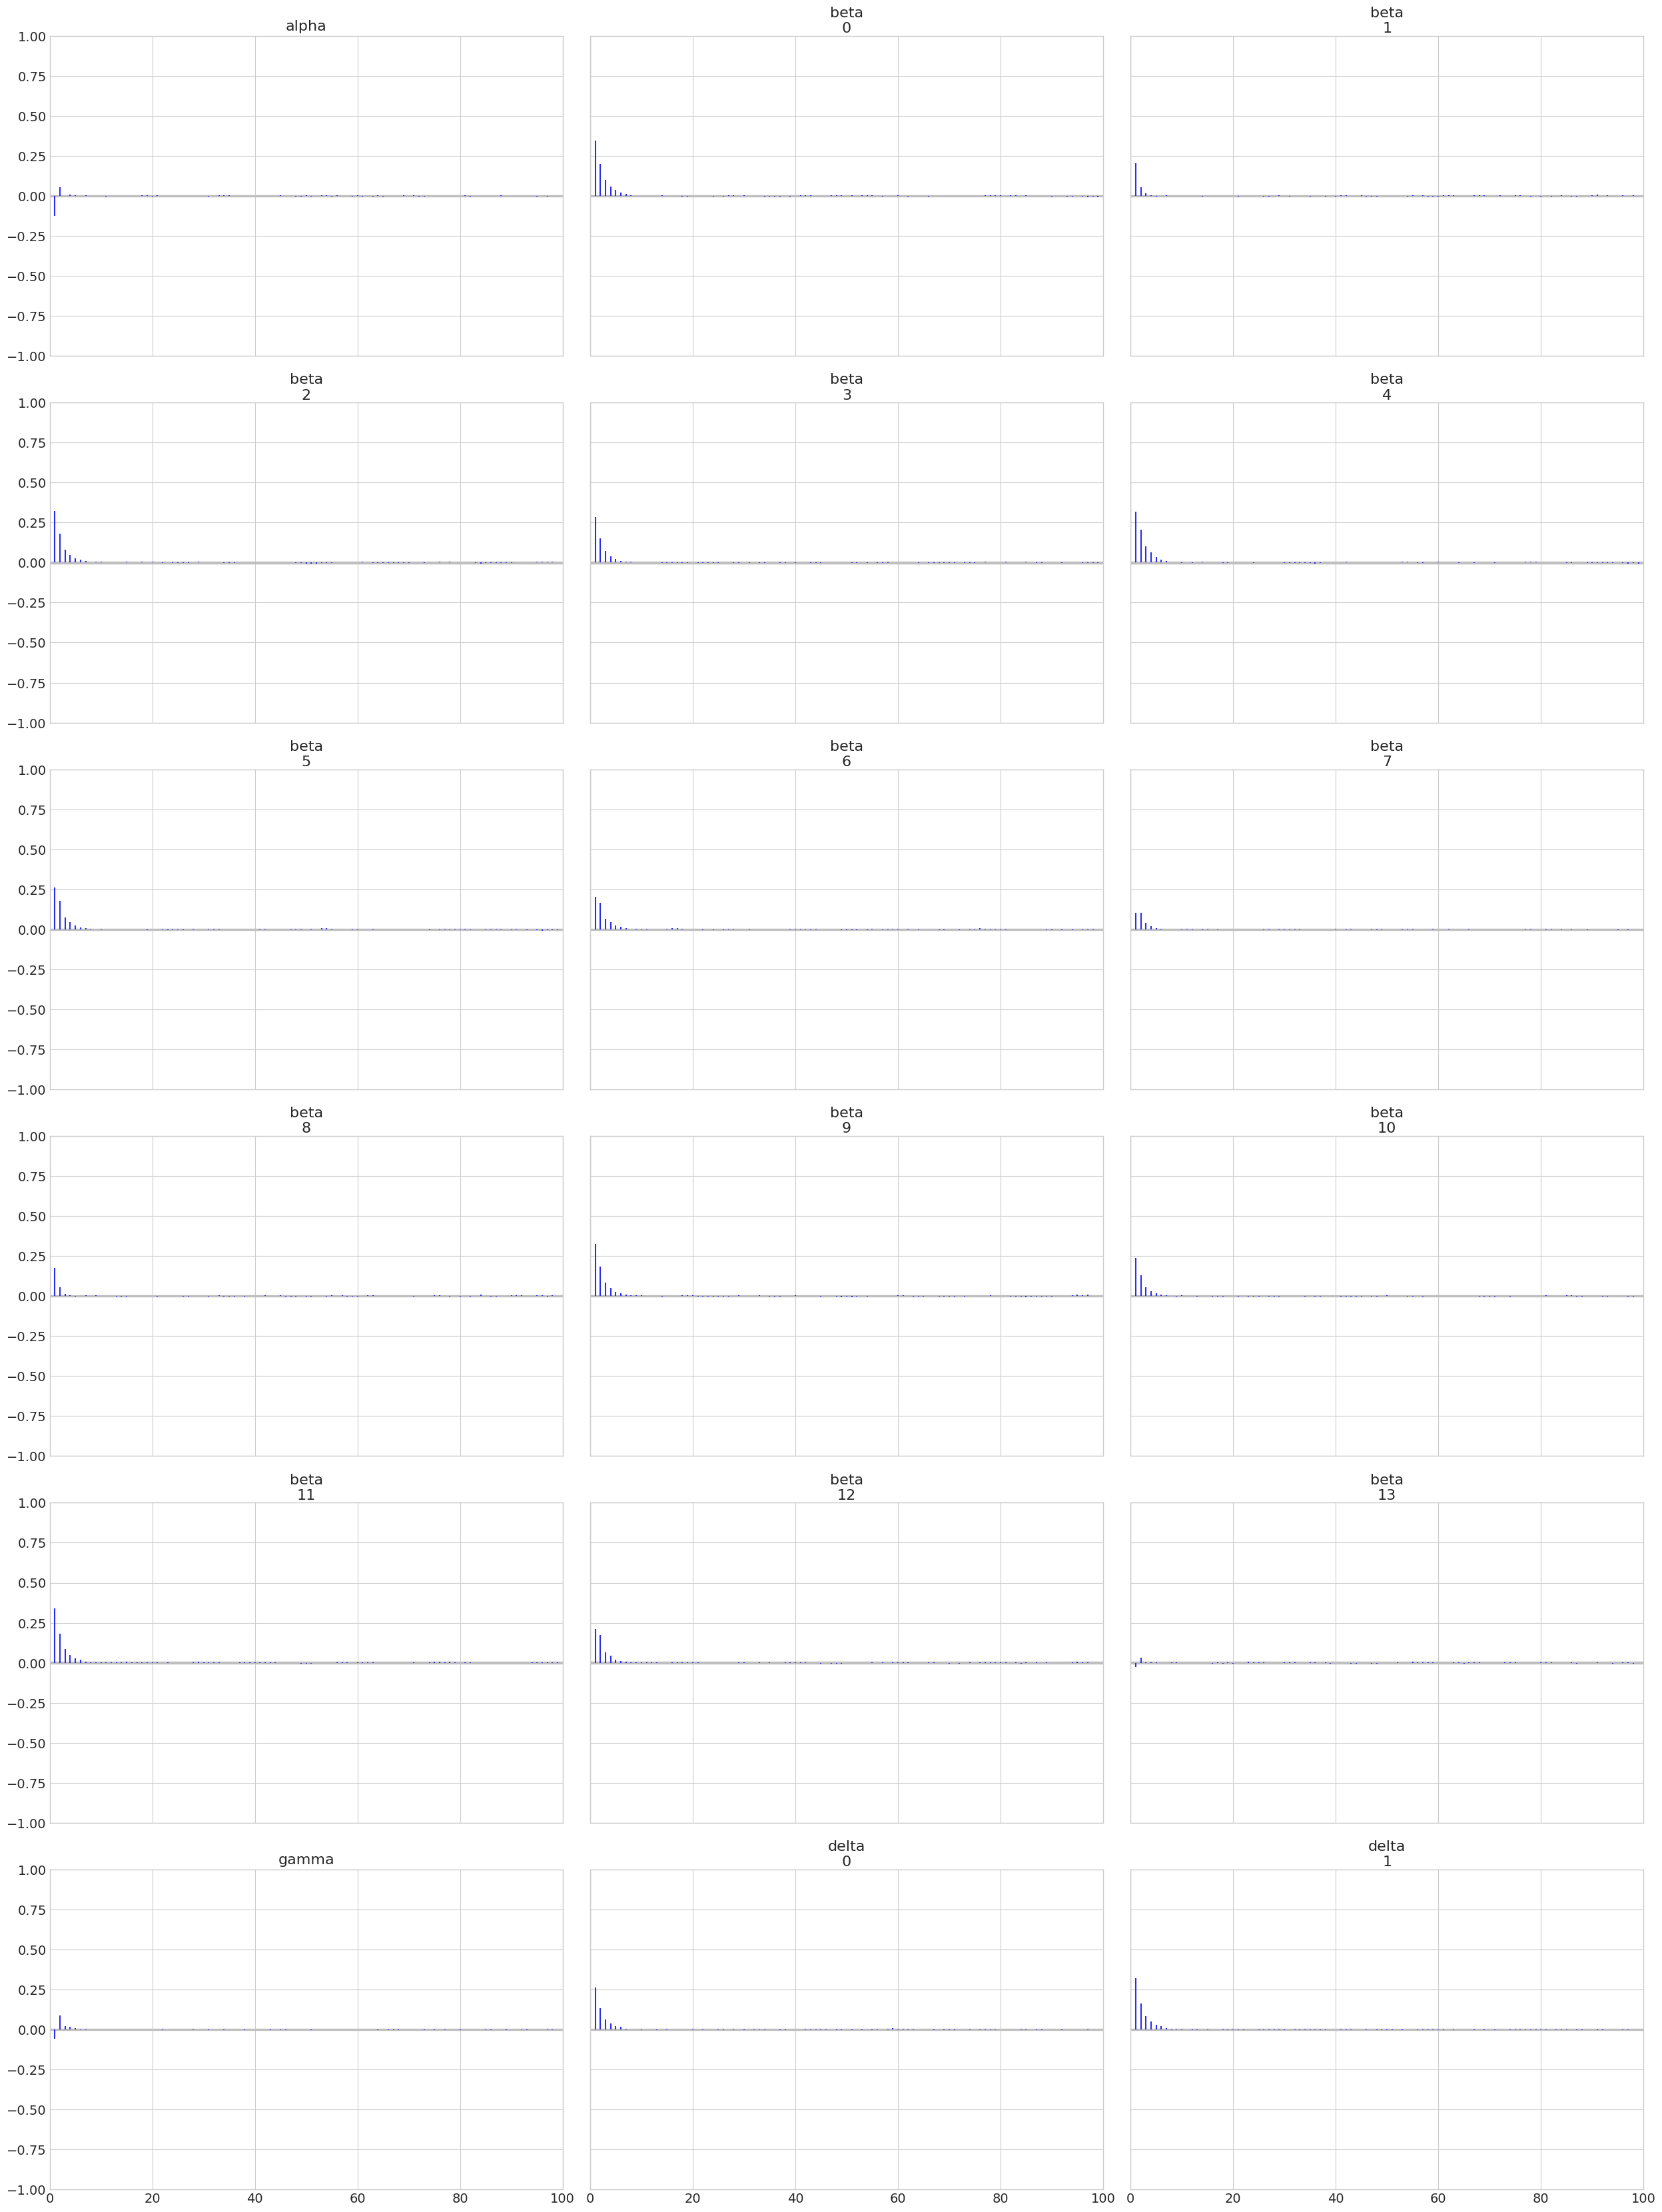

In [68]:
# Plot auto-correlation plots
az.plot_autocorr(trace, var_names=['alpha', 'beta', 'gamma', 'delta'], combined=True)
plt.plot()

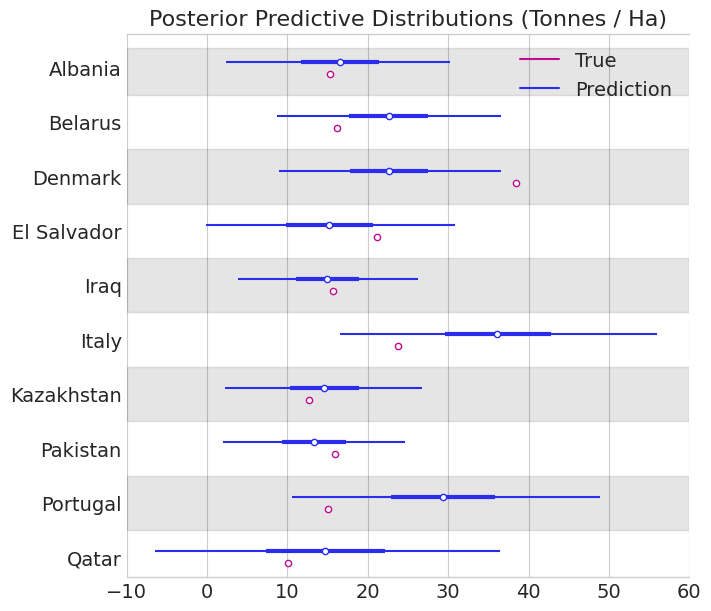

In [69]:
# Sample the predictions and plot them
ppc, pred_samples = pymc3_sample_predictions(model, trace)
pred_samples = y_stddev * pred_samples + y_mean
plot_predictions(
    pred_samples, y_data, test_indices, sample_ids=countries, transform=lambda x: 1e-4 * x,
    xlim=(-10, 60), title='Posterior Predictive Distributions (Tonnes / Ha)'
)

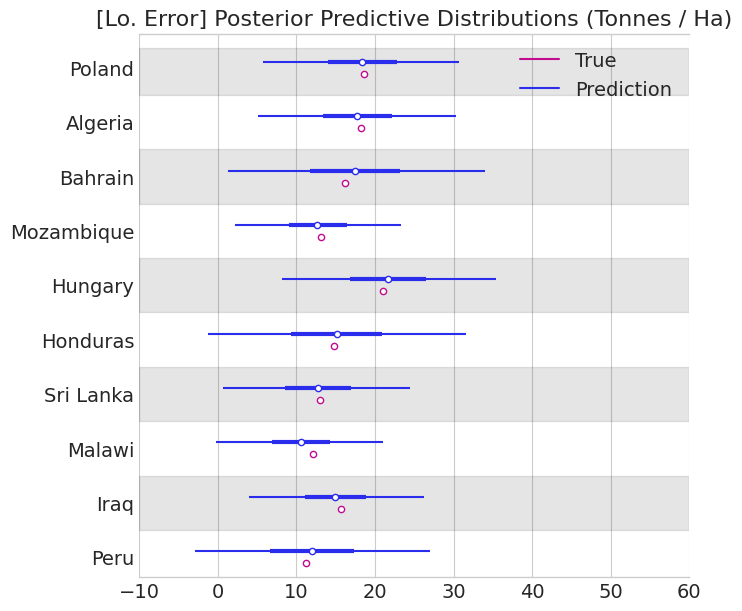

In [70]:
# Plot the predictions of the countries having lowest error
plot_predictions(
    pred_samples, y_data, results['quadratic']['err_indices'][0], sample_ids=countries, transform=lambda x: 1e-4 * x,
    xlim=(-10, 60), title='[Lo. Error] Posterior Predictive Distributions (Tonnes / Ha)'
)

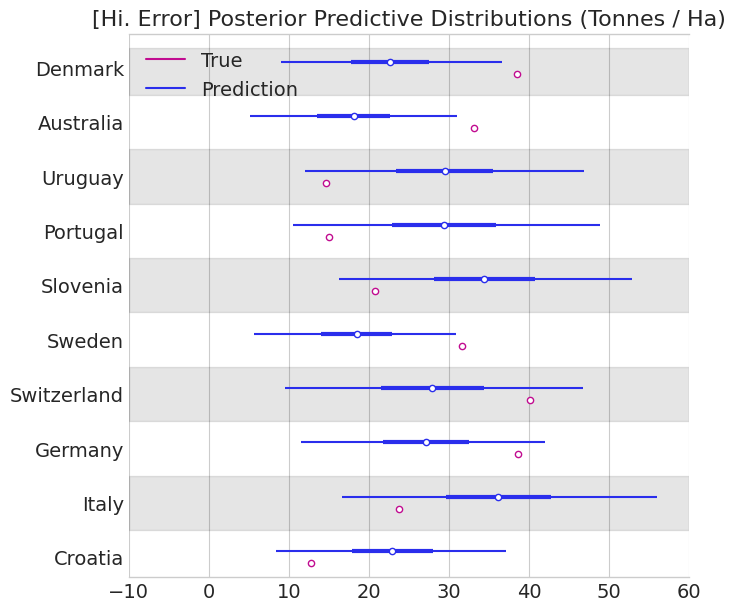

In [71]:
# Plot the predictions of the countries having highest error
plot_predictions(
    pred_samples, y_data, results['quadratic']['err_indices'][1], sample_ids=countries, transform=lambda x: 1e-4 * x,
    xlim=(-10, 60), title='[Hi. Error] Posterior Predictive Distributions (Tonnes / Ha)'
)

[]

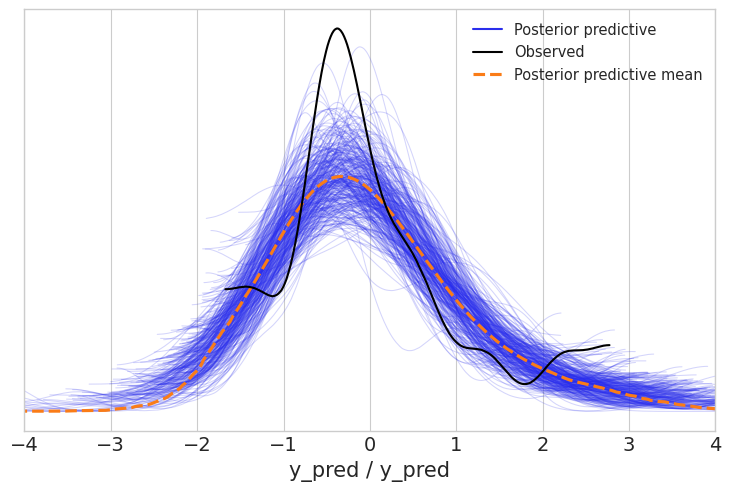

In [72]:
# Posterior predictive check
ppc_data = az.from_pymc3(posterior_predictive=ppc, model=model)
ax = az.plot_ppc(ppc_data, num_pp_samples=320)
ax.set_xlim((-4, 4))
plt.plot()

In [73]:
# Print the average log-likelihood
mu_ll, sigma_ll = compute_average_ll(trace)
print("Quadratic Regression with Variable Variance:")
print("Avg. LL: {:.2f} +- {:.2f}".format(mu_ll, sigma_ll))

Quadratic Regression with Variable Variance:
Avg. LL: -1.06 +- 0.47


In [74]:
# Print MAE
mae = compute_mae(pred_samples, y_data)
print("Quadratic Regression with Variable Variance:")
print("MAE: {:.2f} (Tonnes / Ha)".format(mae * 1e-4))

Quadratic Regression with Variable Variance:
MAE: 4.89 (Tonnes / Ha)


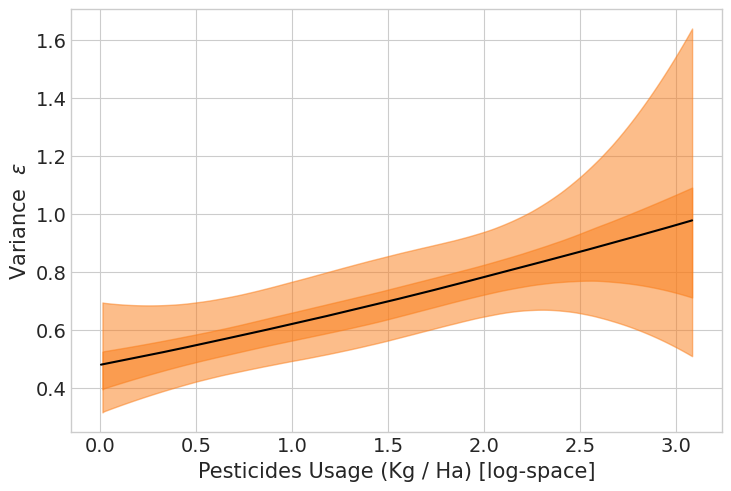

In [75]:
lx = np.linspace(np.log(1.0 + x_data['pesticides_kg_per_ha'].min()), np.log(1.0 + x_data['pesticides_kg_per_ha'].max()), 200)
nlx = np.stack([lx, lx ** 2], axis=1)
nlx = (nlx - np.mean(nlx, axis=0)) / np.std(nlx, axis=0)
ly = np.exp(np.expand_dims(trace.posterior['gamma'], axis=2) + np.dot(trace.posterior['delta'], nlx.T))
ly = np.clip(ly, 2e-4, 2e1)
ax = az.plot_hdi(lx, ly, hdi_prob=0.94)
ax = az.plot_hdi(lx, ly, hdi_prob=0.50)
ax.plot(lx, np.median(ly, axis=(0, 1)), c='k')
ax.set_xlabel('Pesticides Usage (Kg / Ha) [log-space]'); ax.set_ylabel('Variance  $\epsilon$')
plt.show()

In [76]:
# Save results
results['quadratic_vv'] = {
    'metrics': {'ll': (mu_ll, sigma_ll), 'mae': mae},
    'ppc_data': ppc_data,
    'pred_samples': pred_samples,
    'err_indices': results['quadratic']['err_indices']
}

### Comparison

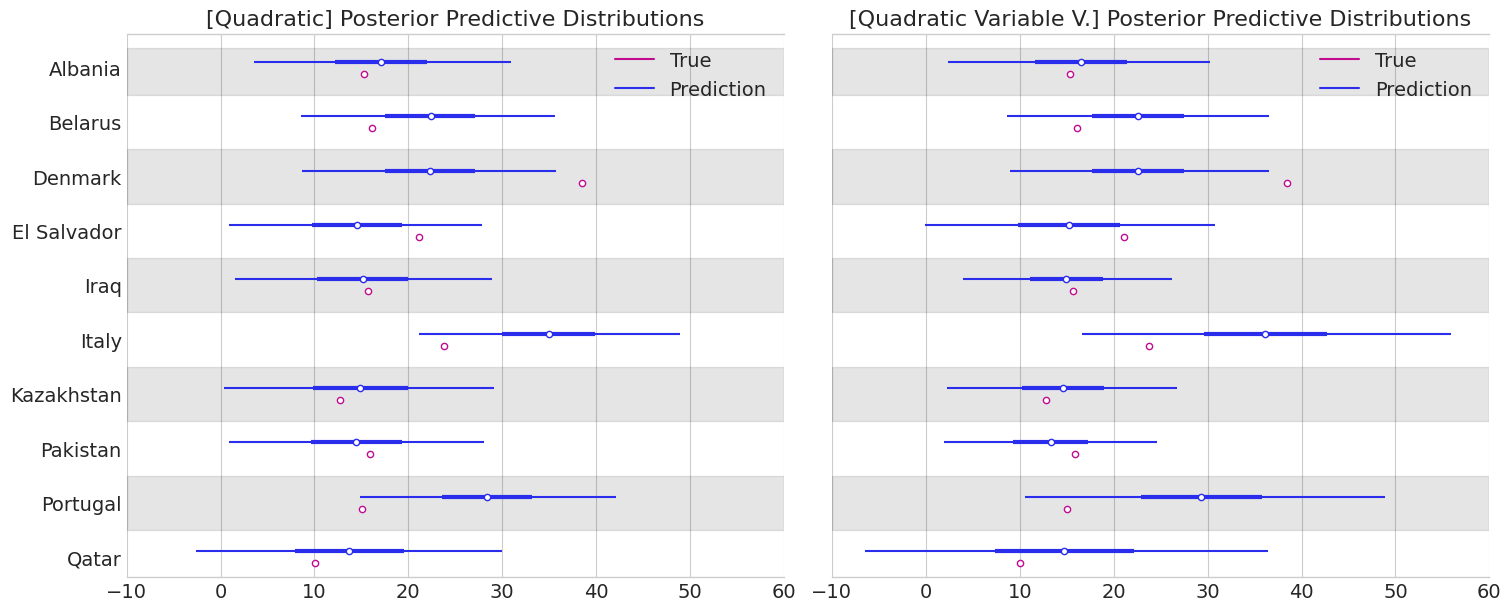

In [77]:
# Plot comparison of predictions
plot_predictions_compare(
    results['quadratic']['pred_samples'], results['quadratic_vv']['pred_samples'], y_data, test_indices, sample_ids=countries, transform=lambda x: 1e-4 * x,
    xlim=(-10, 60), titles=('[Quadratic] Posterior Predictive Distributions', '[Quadratic Variable V.] Posterior Predictive Distributions')
)

[]

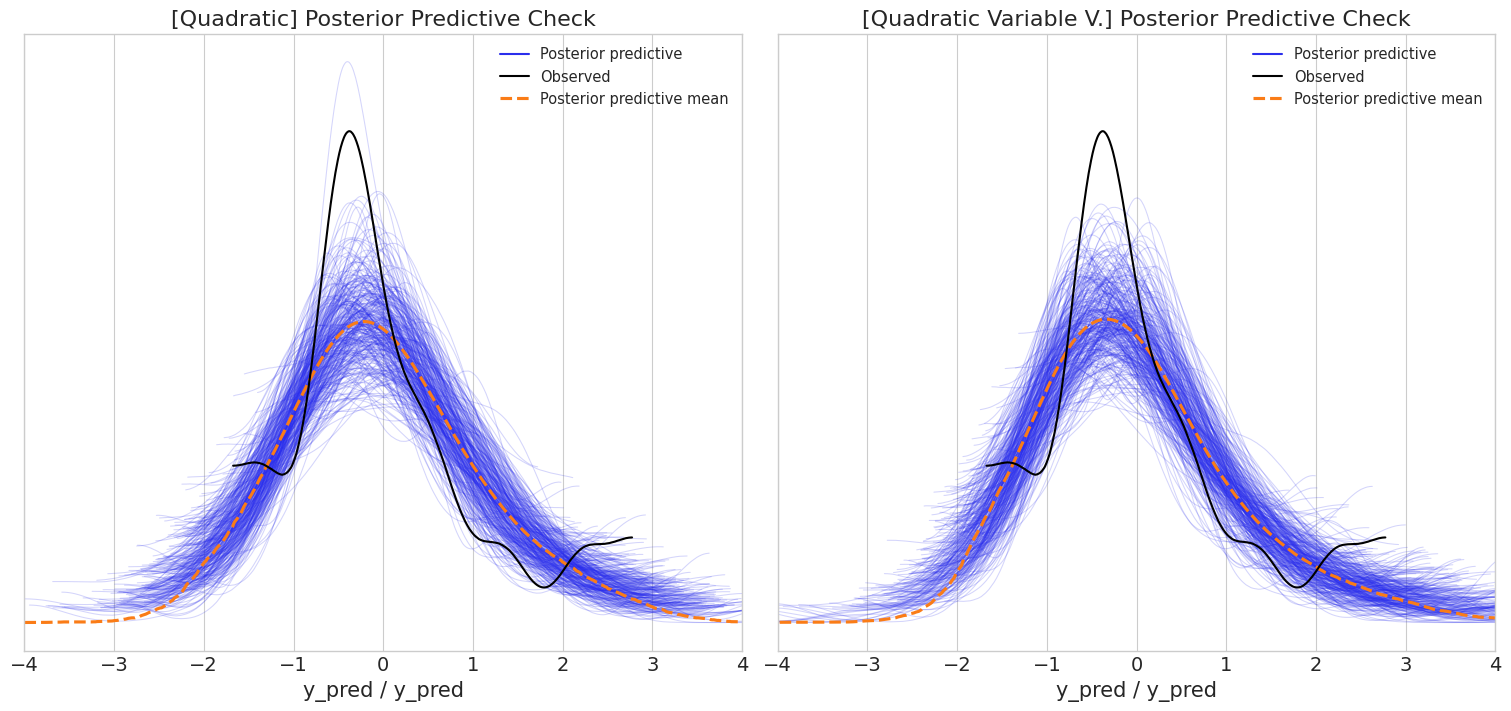

In [78]:
# Posterior predictive check comparison
fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)
az.plot_ppc(results['quadratic']['ppc_data'], num_pp_samples=320, ax=ax[0])
az.plot_ppc(results['quadratic_vv']['ppc_data'], num_pp_samples=320, ax=ax[1])
ax[0].set_xlim((-4, 4)); ax[1].set_xlim((-4, 4))
ax[0].set_title('[Quadratic] Posterior Predictive Check'); ax[1].set_title('[Quadratic Variable V.] Posterior Predictive Check')
plt.plot()

# Splines

Until now, we built our regression model as a single (multivariate) polynomial model (e.g. linear regression or polynomial regression).
However, we can consider different polynomials in different regions of the features space.
For example, we can use a piecewise cubic function defined as follows.

$$\mu = \begin{cases}
\alpha_1 + \beta_{11}X + \beta_{12}X^2 + \beta_{13}X^3 & \text{if}\ X < \xi \\
\alpha_2 + \beta_{21}X + \beta_{22}X^2 + \beta_{23}X^3 & \text{if}\ X \geq \xi 
\end{cases}$$

$$Y \sim \mathcal{N}(\mu,\epsilon)$$

where $\xi$ is a **knot** in the features space.

We can have an arbitrarily number of knots $\xi_1,\xi_2,\ldots,\xi_K$ and $K+1$ different local functions, such that $\xi_i < \xi_j$ if and only if $i<j$.
However, we do _not_ want _discontinuities_ in our overall function.
**Splines** are piecewice functions that satisfy continuity, and in some cases even _differentiability_.

A **linear spline** with knots $\xi_1,\xi_2,\ldots,\xi_K$ is a piecewise linear function which is continuous at each knot.
From a Bayesian point of view, a linear spline can be written as follows in terms of linear combination of basis functions.

$$\mu=\alpha + \sum_{i=1}^{K+1}\beta_iB_i(X) \qquad Y\sim\mathcal{N}(\mu,\epsilon)$$

$$B_1(X) = X \qquad B_{k+1}(X) = (X-\xi_k)_+ \qquad 1\leq k\leq K$$

where $(X-\xi)_+$ denotes $\max(0,X-\xi)$.

The choice of knots $\xi_1,\xi_2,\ldots,\xi_K$ is not trivial and depends on the data.
A straightforward way to set such points is to cover the features space _uniformly_.
Another way is to set them by using _quantiles_ of the input features distribution.

We can also have multi-variate and polynomial splines too !

In [79]:
def design_matrix_linear_spline(df, knots, knots_selection='uniform'):
    assert knots_selection in ['quantiles', 'uniform']

    # Initialize knots
    if isinstance(knots, int):
        n_knots = knots
        assert n_knots > 0
        if knots_selection == 'quantiles':
            qs = np.arange(1, n_knots + 1) / (n_knots + 1)
            knots = df.quantile(qs).reset_index(drop=True)
            knots = {knots.columns[i]: q for i, q in enumerate(knots.to_numpy().T)}
        elif knots_selection == 'uniform':
            knots = {
                h: np.histogram_bin_edges(df[h], bins=n_knots + 1)[1:-1]
                for h in df.columns
            }
    else:
        ls = [len(v) for v in knots.values()]
        assert len(set(ls)) == 1
        n_knots = ls[0]

    spl_df = dict()
    for h in df.columns:
        # Compute max(x-c_i, 0.0) for each knot c_i
        x_knots = np.asarray(knots[h])
        x = df[h].to_numpy()[:, np.newaxis]
        x = np.maximum(x - x_knots, 0.0)

        # Add features
        headers = ['{}[{}]'.format(h, i + 1) for i in range(n_knots)]
        for i, h in enumerate(headers):
            spl_df[h] = x[:, i]

    # Return the resulting dataframe
    return pd.concat([df, pd.DataFrame(spl_df)], axis=1), knots

We define the method `design_matrix_linear_spline` that computes the corresponding linear spline design matrix, given the number of knots and the method for initializing knots.

In [80]:
df = pd.DataFrame({'X': [0.3, 0.5, -1.0, 0.2, 0.8], 'Y': [0.5, 1.0, 1.0, 0.5, 0.3]})
display(df)
spl_df, knots = design_matrix_linear_spline(df, knots=2, knots_selection='uniform')
display(pd.DataFrame(knots))
display(spl_df.round(4))

X    Y
0  0.3  0.5
1  0.5  1.0
2 -1.0  1.0
3  0.2  0.5
4  0.8  0.3

X         Y
0 -0.4  0.533333
1  0.2  0.766667

X    Y  X[1]  X[2]    Y[1]    Y[2]
0  0.3  0.5   0.7   0.1  0.0000  0.0000
1  0.5  1.0   0.9   0.3  0.4667  0.2333
2 -1.0  1.0   0.0   0.0  0.4667  0.2333
3  0.2  0.5   0.6   0.0  0.0000  0.0000
4  0.8  0.3   1.2   0.6  0.0000  0.0000

In [81]:
# Generate some sinusoidal data
x = 8.0 * (2.0 * np.random.rand(30) - 1.0)
y = np.sin(0.5 * x) + 0.2 * np.random.randn(len(x))
df = pd.DataFrame({'X': x})
df, knots = design_matrix_linear_spline(df, knots=5, knots_selection='uniform')

# Sample from linear regression model on the obtained design matrix
model = pymc3_linear_regression_model(df, y)
with model:
    trace = pm.sample(
        draws=10_000, tune=10_000, target_accept=0.95,
        chains=3, cores=3, random_seed=42,
        return_inferencedata=True
    )

# Generate the test data
test_x = np.linspace(-8.0, 8.0, 100)
test_y = np.sin(0.5 * test_x)
test_df = pd.DataFrame({'X': test_x})
test_df, knots = design_matrix_linear_spline(test_df, knots=knots)
test_model = pymc3_linear_regression_model(test_df, test_y)

# Sample some targets
with test_model:
    pred_samples = pm.fast_sample_posterior_predictive(trace, var_names=['y_pred'], keep_size=True)
    pred_samples = pred_samples['y_pred']
med_samples = np.median(pred_samples.reshape(-1, pred_samples.shape[2]), axis=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eps, beta, alpha]


Sampling 3 chains for 10_000 tune and 10_000 draw iterations (30_000 + 30_000 draws total) took 365 seconds.


For example, we are interested in fitting a sinusoidal wave using only linear functions.
We can do this by using a linear spline and choosing 5 knots selected based on quantiles.
The resulting model will be a piecewise function consisting of 6 linear regression models.

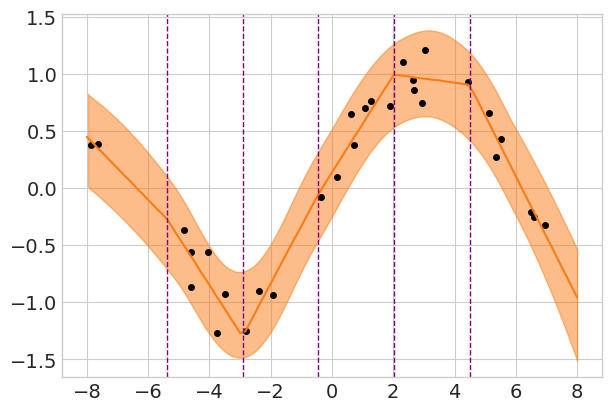

In [82]:
# Plot linear spline with 5 knots (by quantiles) of a noisy sine wave
plt.figure(figsize=(6, 4))
az.plot_hdi(test_x, pred_samples)
plt.scatter(x, y, s=16, c='k')
plt.plot(test_x, med_samples, c='C1')
for k in knots['X']:
    plt.axvline(k, c='purple', linestyle='--', lw=1)
plt.show()

## Linear Splines with PyMC3

In [83]:
# Build design matrix for linear spline regression with 5 knots selected uniformly
features = ['pesticides_kg_per_ha', 'avg_temp', 'elev', 'avg_rain_mm_per_year']
s_dataset, knots = design_matrix_linear_spline(x_data[features], knots=5, knots_selection='uniform')

# Standardize the data
s_dataset, s_mean, s_stddev = standardize_data(s_dataset)
s_dataset.describe()

pesticides_kg_per_ha      avg_temp          elev  avg_rain_mm_per_year  \
count          9.500000e+01  9.500000e+01  9.500000e+01          9.500000e+01   
mean          -4.090295e-18  1.110223e-16 -3.856564e-17         -2.571043e-17   
std            1.005305e+00  1.005305e+00  1.005305e+00          1.005305e+00   
min           -7.794295e-01 -1.957981e+00 -1.044715e+00         -1.397047e+00   
25%           -7.261067e-01 -9.801006e-01 -5.828298e-01         -6.381637e-01   
50%           -3.852796e-01  4.264066e-02 -3.043275e-01         -3.337447e-01   
75%            2.340307e-01  9.515486e-01  3.238023e-01          6.826686e-01   
max            4.404894e+00  1.614850e+00  4.503051e+00          3.203864e+00   

       pesticides_kg_per_ha[1]  pesticides_kg_per_ha[2]  \
count             9.500000e+01             9.500000e+01   
mean              1.752984e-17            -1.285521e-17   
std               1.005305e+00             1.005305e+00   
min              -4.380567e-01            -2.811136e-01   
25%              -4.380567e-01            -2.811136e-01   
50%              -4.380567e-01            -2.811136e-01   
75%              -2.441936e-01            -2.811136e-01   
max               5.167739e+00             6.217766e+00   

       pesticides_kg_per_ha[3]  pesticides_kg_per_ha[4]  \
count             9.500000e+01             9.500000e+01   
mean              5.901712e-17            -1.227089e-17   
std               1.005305e+00             1.005305e+00   
min              -2.019610e-01            -1.508991e-01   
25%              -2.019610e-01            -1.508991e-01   
50%              -2.019610e-01            -1.508991e-01   
75%              -2.019610e-01            -1.508991e-01   
max               7.276556e+00             8.438451e+00   

       pesticides_kg_per_ha[5]   avg_temp[1]  ...       elev[1]       elev[2]  \
count             9.500000e+01  9.500000e+01  ...  9.500000e+01  9.500000e+01   
mean             -1.285521e-17  2.518453e-16  ... -1.869849e-17 -5.258951e-18   
std               1.005305e+00  1.005305e+00  ...  1.005305e+00  1.005305e+00   
min              -1.130835e-01 -1.434063e+00  ... -4.805409e-01 -2.648108e-01   
25%              -1.130835e-01 -1.037965e+00  ... -4.805409e-01 -2.648108e-01   
50%              -1.130835e-01  2.138784e-02  ... -4.805409e-01 -2.648108e-01   
75%              -1.130835e-01  9.628320e-01  ...  5.506231e-02 -2.648108e-01   
max               9.646409e+00  1.649877e+00  ...  5.097797e+00  6.062563e+00   

            elev[3]       elev[4]       elev[5]  avg_rain_mm_per_year[1]  \
count  9.500000e+01  9.500000e+01  9.500000e+01             9.500000e+01   
mean   1.227089e-17 -2.746341e-17  2.921640e-18             2.337312e-17   
std    1.005305e+00  1.005305e+00  1.005305e+00             1.005305e+00   
min   -1.826929e-01 -1.465391e-01 -1.461819e-01            -8.256833e-01   
25%   -1.826929e-01 -1.465391e-01 -1.461819e-01            -8.204209e-01   
50%   -1.826929e-01 -1.465391e-01 -1.461819e-01            -4.929369e-01   
75%   -1.826929e-01 -1.465391e-01 -1.461819e-01             6.477924e-01   
max    6.766078e+00  7.078564e+00  7.346005e+00             3.477352e+00   

       avg_rain_mm_per_year[2]  avg_rain_mm_per_year[3]  \
count             9.500000e+01             9.500000e+01   
mean              2.571043e-17            -3.739699e-17   
std               1.005305e+00             1.005305e+00   
min              -5.450609e-01            -3.168845e-01   
25%              -5.450609e-01            -3.168845e-01   
50%              -5.450609e-01            -3.168845e-01   
75%               3.091505e-01            -3.168845e-01   
max               4.252967e+00             5.325630e+00   

       avg_rain_mm_per_year[4]  avg_rain_mm_per_year[5]  
count             9.500000e+01             9.500000e+01  
mean              5.258951e-18            -1.636118e-17  
std               1.005305e+00             1.005305e+00  
min              -2.109891e-01    

In [84]:
# Build a PyMC3 model for linear spline regression
model = pymc3_linear_regression_model(s_dataset, y_std_data)

# Sample from the posterior
with model:
    trace = pm.sample(
        draws=40_000, tune=20_000, target_accept=0.95,
        chains=3, cores=3, random_seed=42,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eps, beta, alpha]


Sampling 3 chains for 20_000 tune and 40_000 draw iterations (60_000 + 120_000 draws total) took 1436 seconds.


[]

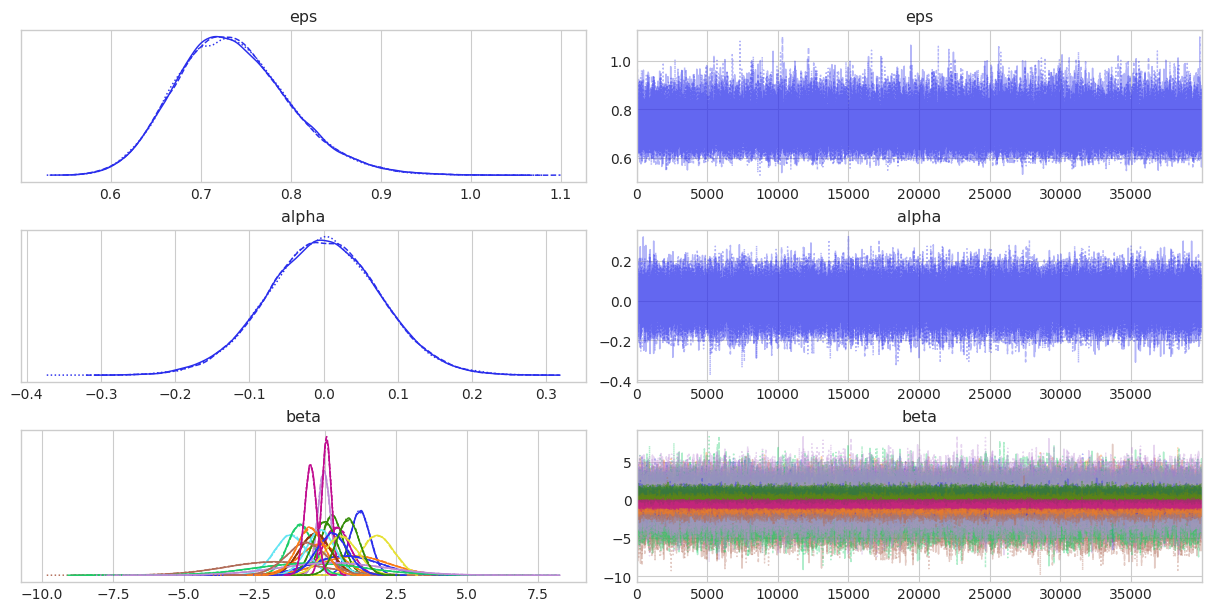

In [85]:
# Plot traces
az.plot_trace(trace, var_names=['eps', 'alpha', 'beta'])
plt.plot()

[]

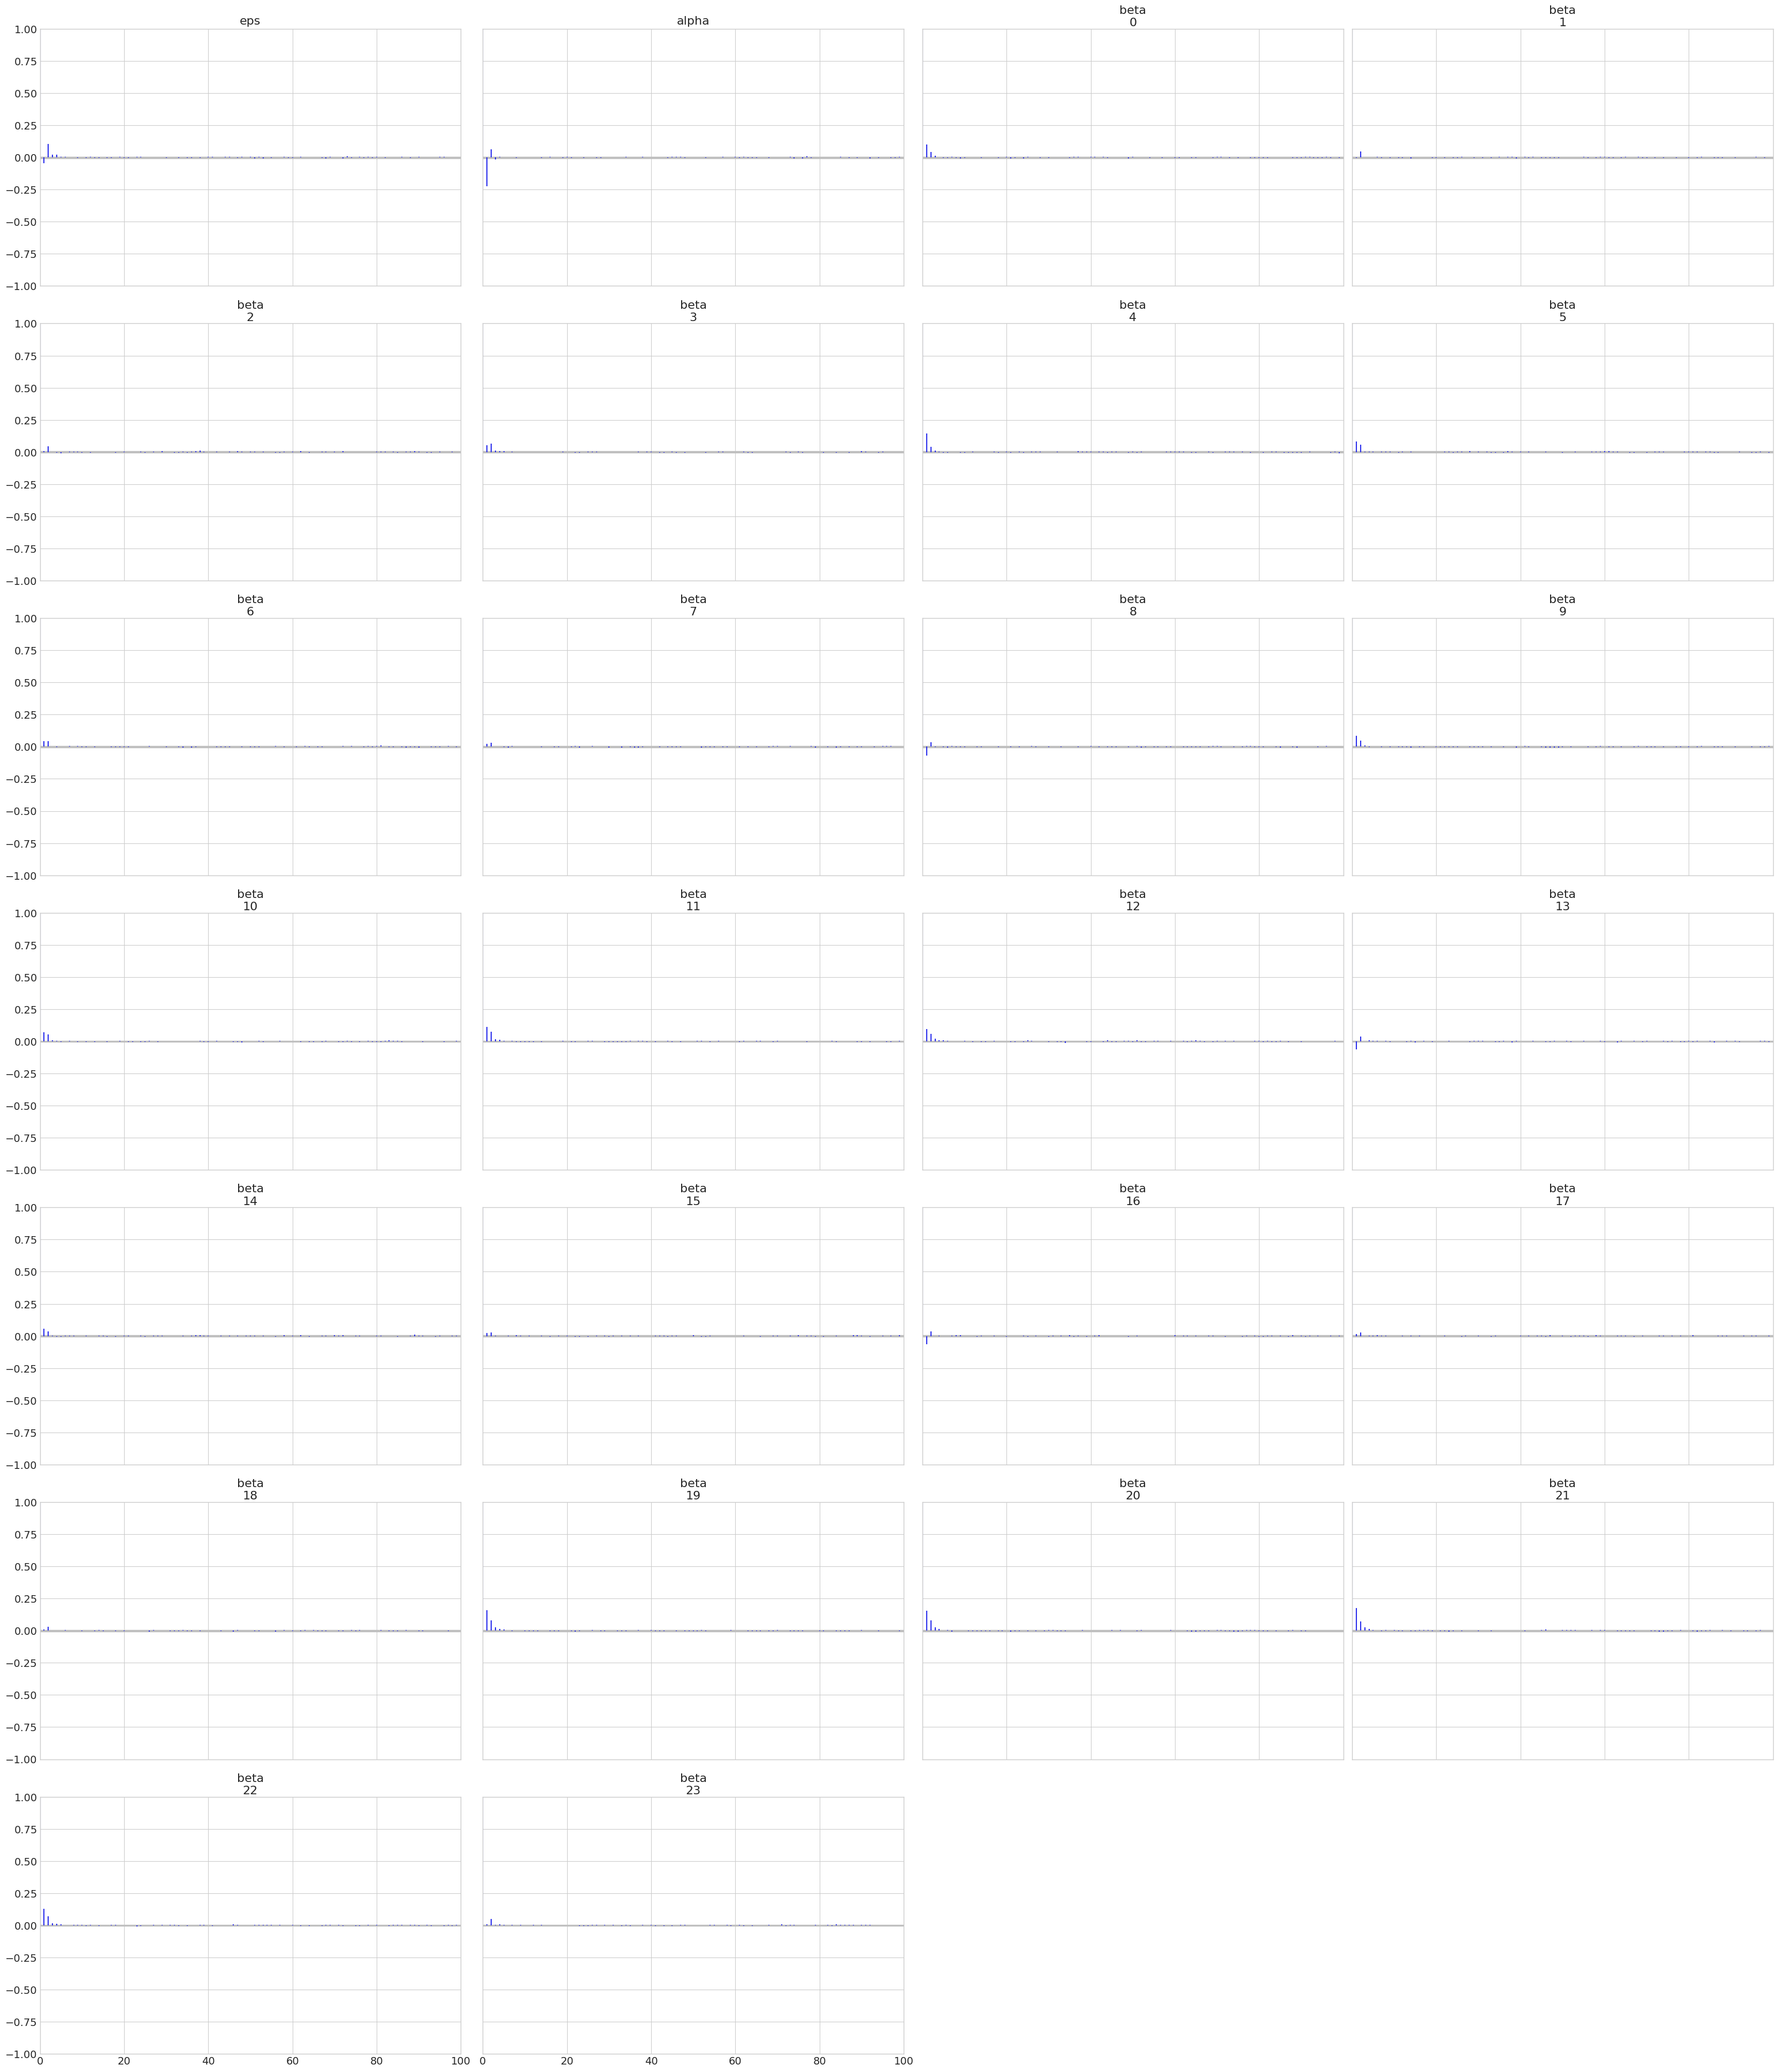

In [86]:
# Plot auto-correlation plots
az.plot_autocorr(trace, var_names=['eps', 'alpha', 'beta'], combined=True)
plt.plot()

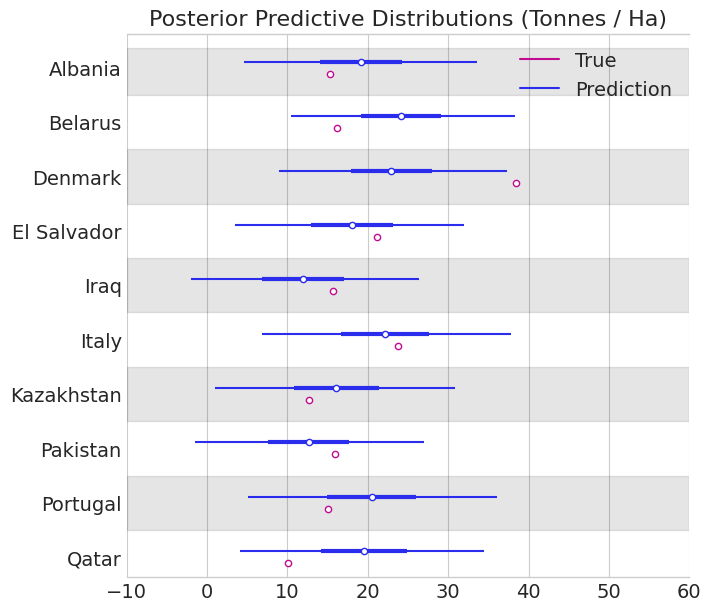

In [87]:
# Sample the predictions and plot them
ppc, pred_samples = pymc3_sample_predictions(model, trace)
pred_samples = y_stddev * pred_samples + y_mean
plot_predictions(
    pred_samples, y_data, test_indices, sample_ids=countries, transform=lambda x: 1e-4 * x,
    xlim=(-10, 60), title='Posterior Predictive Distributions (Tonnes / Ha)'
)

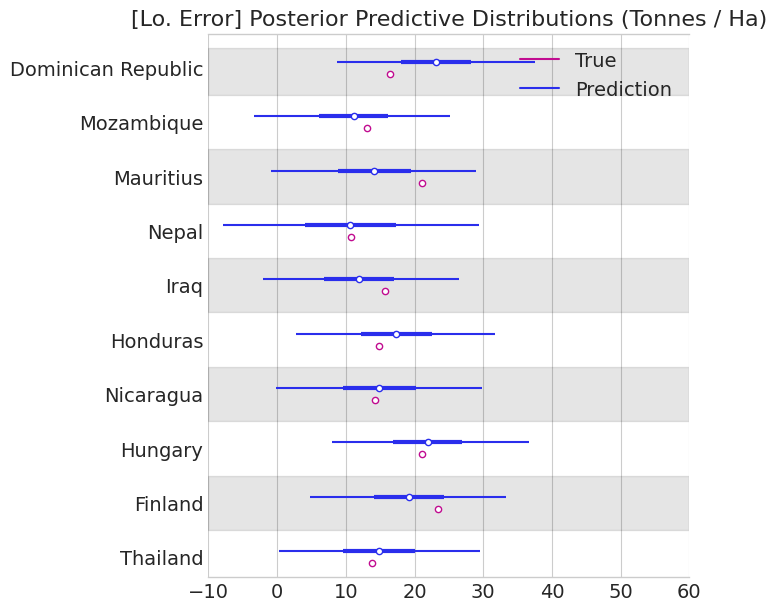

In [88]:
# Plot the predictions of the countries having lowest error
plot_predictions(
    pred_samples, y_data, results['linear']['err_indices'][0], sample_ids=countries, transform=lambda x: 1e-4 * x,
    xlim=(-10, 60), title='[Lo. Error] Posterior Predictive Distributions (Tonnes / Ha)'
)

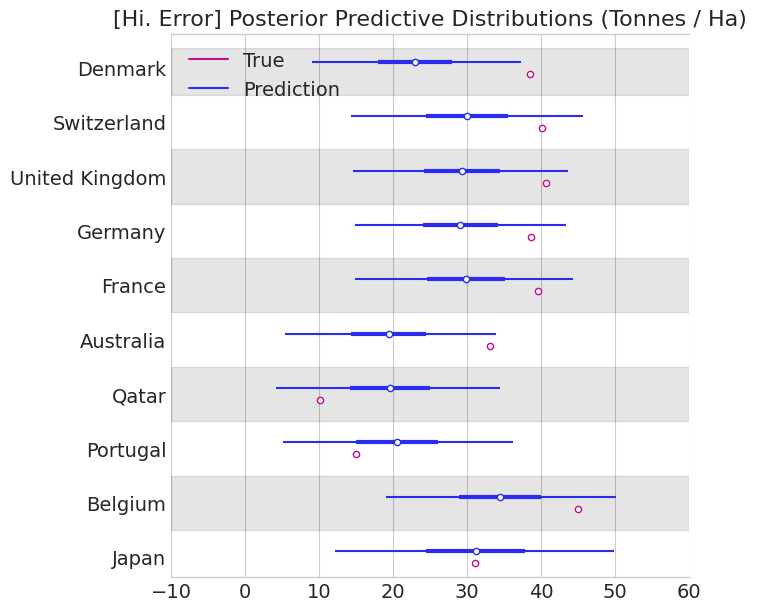

In [89]:
# Plot the predictions of the countries having highest error
plot_predictions(
    pred_samples, y_data, results['linear']['err_indices'][1], sample_ids=countries, transform=lambda x: 1e-4 * x,
    xlim=(-10, 60), title='[Hi. Error] Posterior Predictive Distributions (Tonnes / Ha)'
)

[]

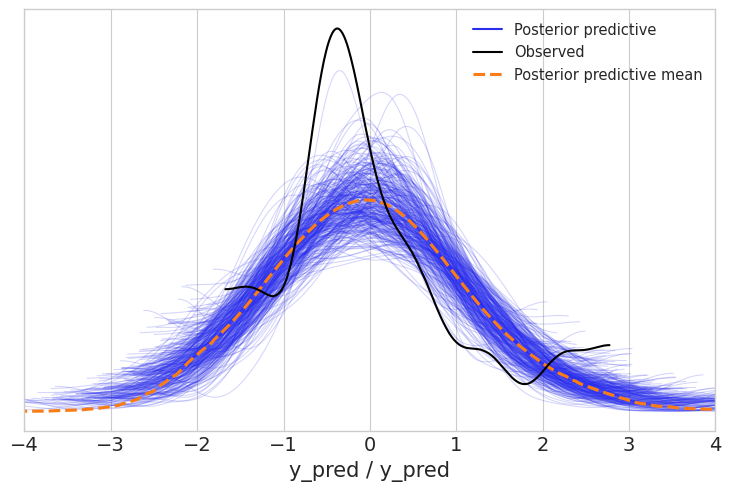

In [90]:
# Posterior predictive check
ppc_data = az.from_pymc3(posterior_predictive=ppc, model=model)
ax = az.plot_ppc(ppc_data, num_pp_samples=320)
ax.set_xlim((-4, 4))
plt.plot()

In [91]:
# Print the average log-likelihood
mu_ll, sigma_ll = compute_average_ll(trace)
print("Multivariate Linear Spline Regression:")
print("Avg. LL: {:.2f} +- {:.2f}".format(mu_ll, sigma_ll))

Multivariate Linear Spline Regression:
Avg. LL: -1.10 +- 0.55


In [92]:
# Print MAE
mae = compute_mae(pred_samples, y_data)
print("Multivariate Linear Spline Regression:")
print("MAE: {:.2f} (Tonnes / Ha)".format(mae * 1e-4))

Multivariate Linear Spline Regression:
MAE: 4.84 (Tonnes / Ha)


In [93]:
# Save results
results['linear_spline'] = {
    'metrics': {'ll': (mu_ll, sigma_ll), 'mae': mae},
    'ppc_data': ppc_data,
    'pred_samples': pred_samples,
    'err_indices': results['linear']['err_indices']
}

### Comparison

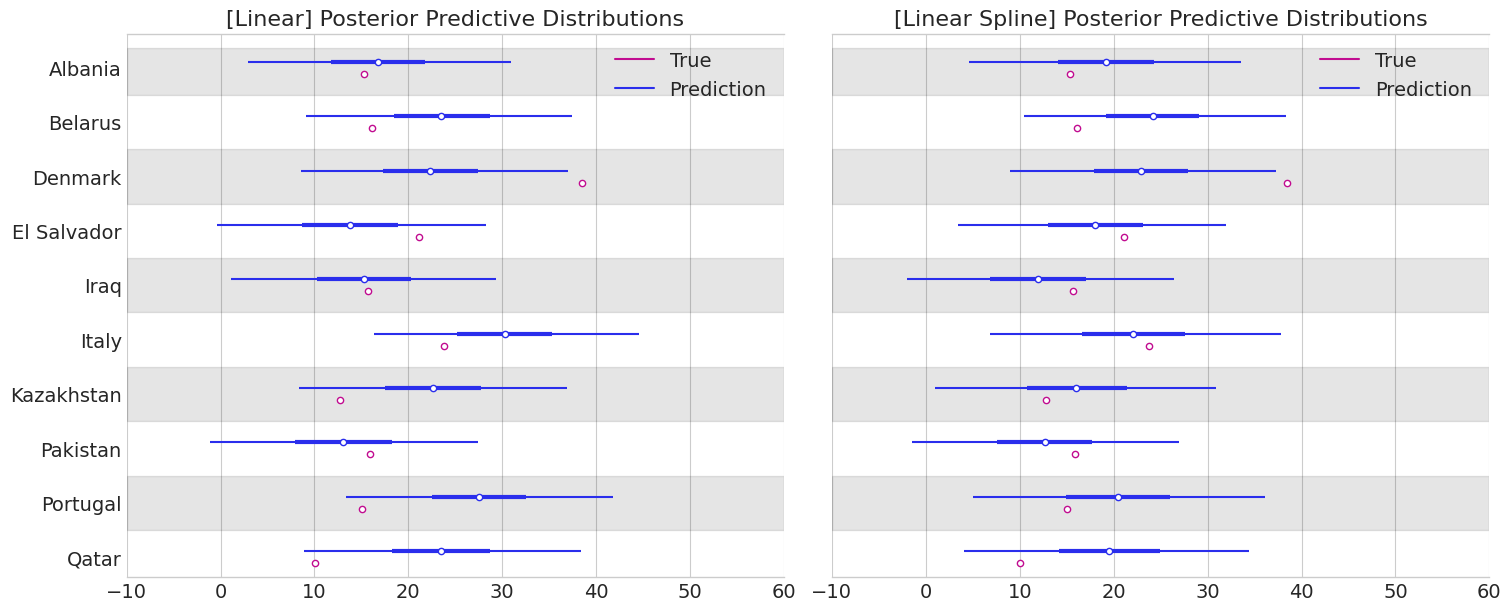

In [94]:
# Plot comparison of predictions
plot_predictions_compare(
    results['linear']['pred_samples'], results['linear_spline']['pred_samples'], y_data, test_indices, sample_ids=countries, transform=lambda x: 1e-4 * x,
    xlim=(-10, 60), titles=('[Linear] Posterior Predictive Distributions', '[Linear Spline] Posterior Predictive Distributions')
)

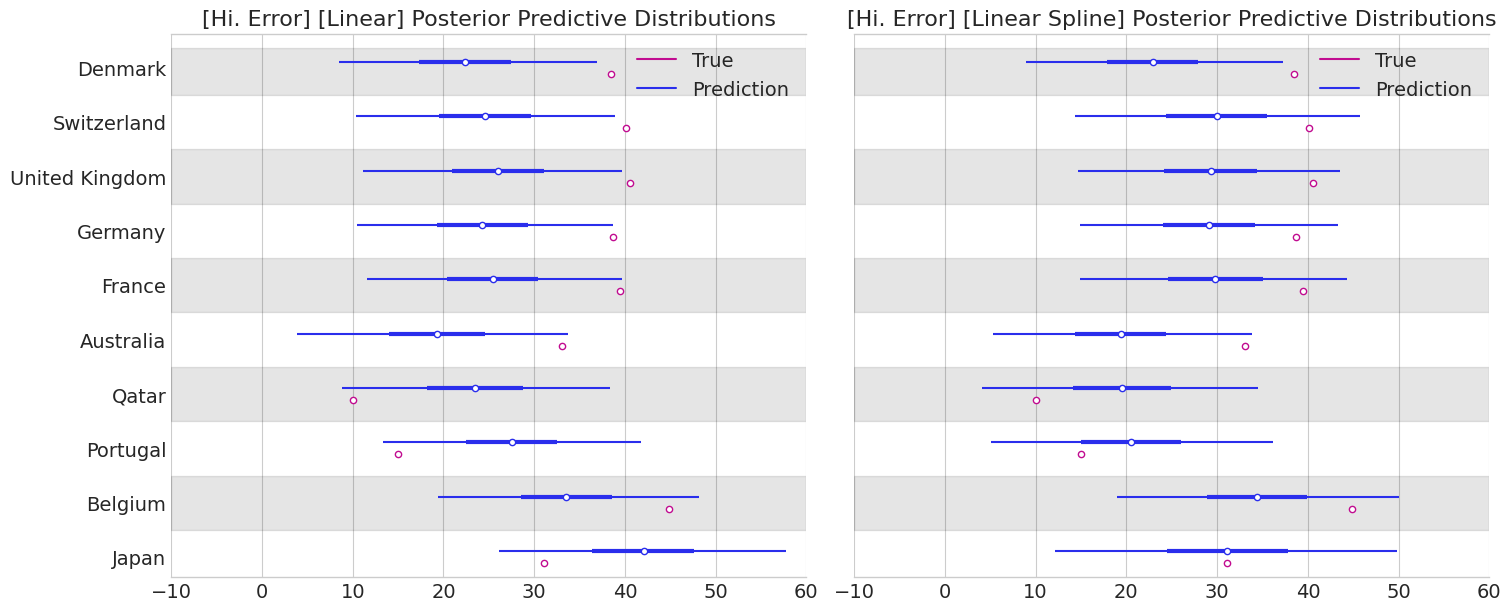

In [95]:
# Plot comparison of predictions
plot_predictions_compare(
    results['linear']['pred_samples'], results['linear_spline']['pred_samples'], y_data, results['linear']['err_indices'][1], sample_ids=countries, transform=lambda x: 1e-4 * x,
    xlim=(-10, 60), titles=('[Hi. Error] [Linear] Posterior Predictive Distributions', '[Hi. Error] [Linear Spline] Posterior Predictive Distributions')
)

[]

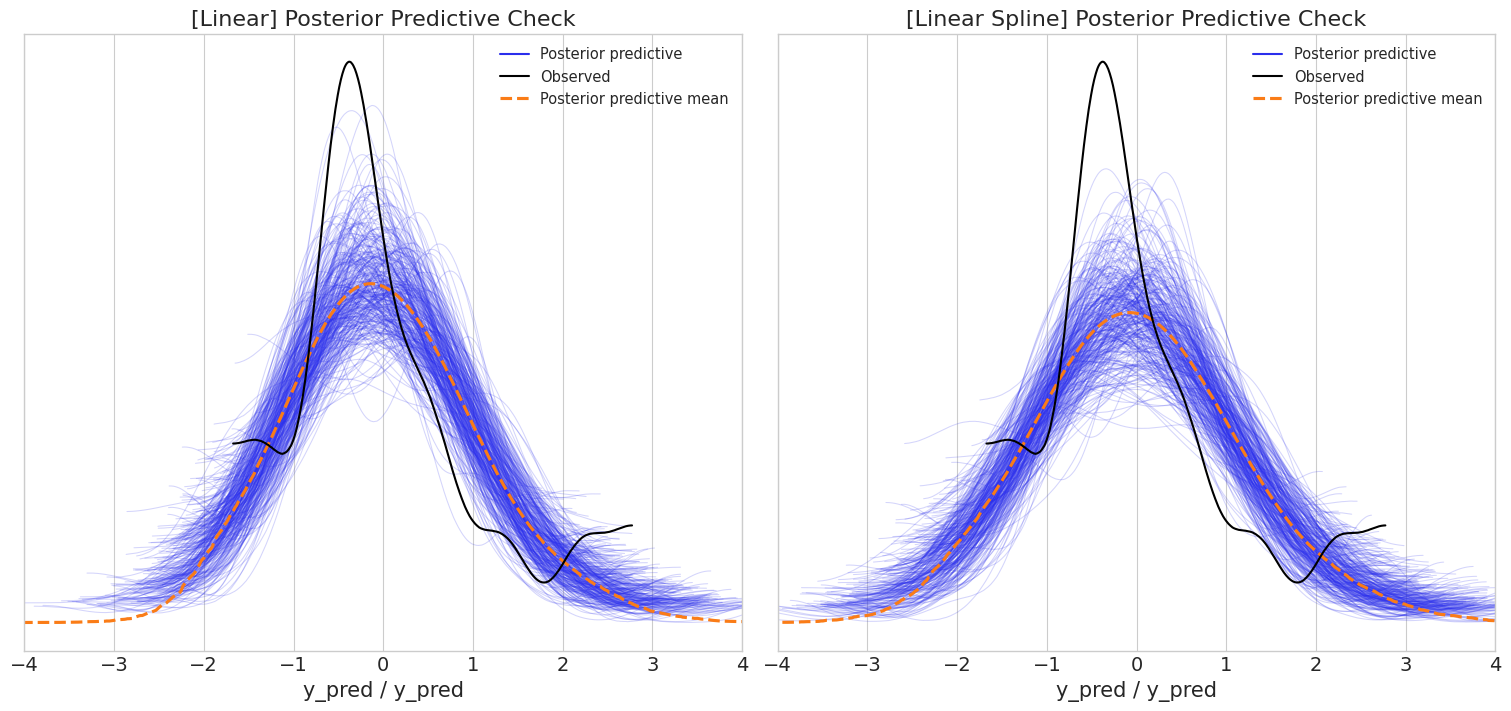

In [96]:
# Posterior predictive check comparison
fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)
az.plot_ppc(results['linear']['ppc_data'], num_pp_samples=320, ax=ax[0])
az.plot_ppc(results['linear_spline']['ppc_data'], num_pp_samples=320, ax=ax[1])
ax[0].set_xlim((-4, 4)); ax[1].set_xlim((-4, 4))
ax[0].set_title('[Linear] Posterior Predictive Check'); ax[1].set_title('[Linear Spline] Posterior Predictive Check')
plt.plot()

# Conclusion

- Quadratic models are more accurate than a linear model

- The usage of pesticides play a major role in both the predictions and the quantification of uncertainty

- Linear splines can model non-linearities, but they are computationally heavy to sample

- Posterior Predictive Checks (PPC) are useful for evaluate Bayesian models

In [97]:
# Save results to (compressed) file
with gzip.open('yields-regression-results.pickle.gz', 'wb') as f:
    f.write(pickle.dumps(results))